# **2 Unsupervised Learning: Identifying Trade Patterns (40)**

## **1. Normalize the trade data (e.g., using min–max scaling or standardization) to make sector level measures comparable across countries . Aggregate export values into broad two-digit product categories (the first two digits of the HS code) for 2016–2018 and convert them into export-share vectors for each country. (10 points)**

### 步骤1.1：数据读取与时间筛选

#### 读取2016-2018年的贸易数据文件

In [2]:
# --- 步骤 1.1.1：读取2016-2018年贸易数据 ---
import pandas as pd
import os

# 定义路径
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'raw', 'trade_data')
years = [2016, 2017, 2018]
dataframes = []

for year in years:
    filename = f'baci_hs12_y{year}_v202001.csv'
    filepath = os.path.join(base_dir, filename)
    
    print(f"正在读取 {filename}...")
    df = pd.read_csv(filepath, low_memory=False)  # 防止 dtype warning
    dataframes.append(df)

print("所有年份数据已成功读取。")

正在读取 baci_hs12_y2016_v202001.csv...
正在读取 baci_hs12_y2017_v202001.csv...
正在读取 baci_hs12_y2018_v202001.csv...
所有年份数据已成功读取。


#### 筛选仅保留指定年份的数据（2016-2018）

In [3]:
# --- 步骤 1.1.2：筛选并验证仅保留2016-2018年数据 ---
# 合并所有年份数据
df_trade = pd.concat(dataframes, ignore_index=True)

# 检查数据中的年份列 't' 是否都在 2016-2018 范围内
print("\n--- 检查年份范围 ---")
unique_years = df_trade['t'].unique()
print(f"数据中包含的年份: {sorted(unique_years)}")

# 筛选仅保留 2016-2018 年的数据（理论上应该全部满足）
df_trade_filtered = df_trade[df_trade['t'].isin([2016, 2017, 2018])]

if len(df_trade_filtered) == len(df_trade):
    print("所有数据均属于 2016-2018 年，无需进一步筛选。")
else:
    print("发现非目标年份数据，已剔除。")
    print(f"原数据行数: {len(df_trade)}, 剔除后行数: {len(df_trade_filtered)}")

# 更新主DataFrame
df_trade = df_trade_filtered.copy()

print(f"当前数据集包含 {len(df_trade)} 行记录。")


--- 检查年份范围 ---
数据中包含的年份: [np.int64(2016), np.int64(2017), np.int64(2018)]
所有数据均属于 2016-2018 年，无需进一步筛选。
当前数据集包含 24025656 行记录。


#### 验证数据完整性，检查缺失值和异常值

In [4]:
# 步骤 1.1.3：验证数据完整性，检查缺失值和异常值

# 1. 检查缺失值
print("缺失值检查")
missing = df_trade.isnull().sum()
print(missing[missing > 0])  # 只显示有缺失的列

if missing.sum() == 0:
    print("没有发现缺失值")

# 2. 检查异常值

# (a) 检查贸易价值 v 和数量 q 是否为负数
negative_value = df_trade[df_trade['v'] < 0]
negative_quantity = df_trade[df_trade['q'] < 0]

if len(negative_value) > 0:
    print(f"发现 {len(negative_value)} 条贸易价值 v 为负数")
else:
    print("贸易价值 v 无负数")

if len(negative_quantity) > 0:
    print(f"发现 {len(negative_quantity)} 条贸易数量 q 为负数")
else:
    print("贸易数量 q 无负数")

# (b) 检查国家代码 i 和 j 是否合理
invalid_i = df_trade[(df_trade['i'] < 1) | (df_trade['i'] > 999)]
invalid_j = df_trade[(df_trade['j'] < 1) | (df_trade['j'] > 999)]

if len(invalid_i) > 0:
    print(f"发现 {len(invalid_i)} 条 exporter 国家代码 i 异常")
else:
    print("exporter 国家代码 i 合理")

if len(invalid_j) > 0:
    print(f"发现 {len(invalid_j)} 条 importer 国家代码 j 异常")
else:
    print("importer 国家代码 j 合理")

# (c) 检查 HS6 产品代码 k 长度是否为 6 位
df_trade['k_str'] = df_trade['k'].astype(str)
df_trade['k_len'] = df_trade['k_str'].str.len()

incorrect_length = df_trade[df_trade['k_len'] != 6]
if len(incorrect_length) > 0:
    print(f"发现 {len(incorrect_length)} 条 HS6 产品代码 k 长度不为 6")
    print("将自动补前导零")
    df_trade['k'] = df_trade['k_str'].str.zfill(6).astype(int)  # 补零并转回 int
else:
    print("HS6 产品代码 k 长度均为 6 位")

# 清理临时列
df_trade.drop(columns=['k_str', 'k_len'], inplace=True)

# 输出最终统计
print(f"最终数据状态")
print(f"总行数 {len(df_trade)}")
print(f"年份分布 {df_trade['t'].value_counts().sort_index()}")

# 保存清洗后的数据到
results_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_cleaned_trade_data_2016_2018.csv')
df_trade.to_csv(results_path, index=False)
print(f"清洗后的数据已保存至 {results_path}")

缺失值检查
Series([], dtype: int64)
没有发现缺失值
贸易价值 v 无负数
贸易数量 q 无负数
exporter 国家代码 i 合理
importer 国家代码 j 合理
发现 1157016 条 HS6 产品代码 k 长度不为 6
将自动补前导零
最终数据状态
总行数 24025656
年份分布 t
2016    7892508
2017    8132873
2018    8000275
Name: count, dtype: int64
清洗后的数据已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_cleaned_trade_data_2016_2018.csv


### 步骤1.2：HS代码标准化处理

#### 读取产品代码参考文件

In [5]:
# 步骤 1.2.1：读取产品代码参考文件
import pandas as pd

# 定义产品代码文件路径
product_code_file = os.path.join(base_dir, 'product_codes_hs12_V202001.csv')

# 读取产品代码参考文件
print("正在读取产品代码参考文件...")
df_products = pd.read_csv(product_code_file)

# 展示前几行以了解结构
print("产品代码文件前5行预览：")
print(df_products.head())

# 检查关键列是否存在 (假设列名为 'code' 和 'description')
# 如果列名不同，请相应调整
if 'code' in df_products.columns and 'description' in df_products.columns:
    print("产品代码文件读取成功，包含 'code' 和 'description' 列")
else:
    # 尝试打印列名以便调试
    print(f"产品代码文件的列名: {list(df_products.columns)}")
    print("请检查列名是否符合预期，并在代码中进行调整")

print("步骤 1.2.1 完成")

正在读取产品代码参考文件...
产品代码文件前5行预览：
    code                                        description
0  10121           Horses: live, pure-bred breeding animals
1  10129  Horses: live, other than pure-bred breeding an...
2  10130                                        Asses: live
3  10190                            Mules and hinnies: live
4  10221           Cattle: live, pure-bred breeding animals
产品代码文件读取成功，包含 'code' 和 'description' 列
步骤 1.2.1 完成


#### 将HS6代码统一格式化为6位字符串并处理前导零

In [6]:
# 假设 df_trade 是上一步处理好的贸易数据 DataFrame

# 检查 df_trade 是否已定义 (从上一步继承)
try:
    # 尝试访问 df_trade 的列来确认其存在
    _ = df_trade.shape 
except NameError:
    print("错误: 上一步的贸易数据 DataFrame 'df_trade' 未找到 请确保上一步已成功运行")
    raise

print("开始处理HS6代码格式...")

# 将贸易数据中的 HS6 代码 (k 列) 转换为字符串
df_trade['k_str'] = df_trade['k'].astype(str)

# 检查转换前的长度分布 (可选，用于诊断)
print("HS6代码字符串长度分布 (处理前):")
print(df_trade['k_str'].str.len().value_counts().sort_index())

# 使用 zfill(6) 确保所有HS6代码都是6位，不足的补前导零
df_trade['hs6_code'] = df_trade['k_str'].str.zfill(6)

# 验证处理结果
print("HS6代码字符串长度分布 (处理后):")
print(df_trade['hs6_code'].str.len().value_counts().sort_index())

# 检查是否有非6位的代码 (理论上应该没有了)
non_six_digit = df_trade[df_trade['hs6_code'].str.len() != 6]
if len(non_six_digit) > 0:
    print(f"警告: 仍有 {len(non_six_digit)} 条记录的 hs6_code 长度不是6")
else:
    print("所有HS6代码均已成功格式化为6位字符串")

# 删除临时的 k_str 列
df_trade.drop(columns=['k_str'], inplace=True)

print("步骤 1.2.2 完成")

开始处理HS6代码格式...
HS6代码字符串长度分布 (处理前):
k_str
5     1157016
6    22868640
Name: count, dtype: int64
HS6代码字符串长度分布 (处理后):
hs6_code
6    24025656
Name: count, dtype: int64
所有HS6代码均已成功格式化为6位字符串
步骤 1.2.2 完成


#### 提取HS2大类代码（取前2位）

In [7]:
# 从已格式化的6位HS6代码中提取前两位作为HS2代码
print("正在提取HS2大类代码...")
df_trade['hs2_code'] = df_trade['hs6_code'].str[:2]

# 验证提取结果
print("提取的HS2代码示例:")
print(df_trade[['hs6_code', 'hs2_code']].head(10))

# 检查HS2代码的唯一值数量和示例
unique_hs2 = df_trade['hs2_code'].nunique()
print(f"总共提取到 {unique_hs2} 个不同的HS2大类代码")

print("常见的HS2代码及其出现次数:")
print(df_trade['hs2_code'].value_counts().head(10))

print("步骤 1.2.3 完成")

正在提取HS2大类代码...
提取的HS2代码示例:
  hs6_code hs2_code
0   080132       08
1   130190       13
2   370239       37
3   970600       97
4   480300       48
5   870333       87
6   850300       85
7   851110       85
8   080620       08
9   081310       08
总共提取到 96 个不同的HS2大类代码
常见的HS2代码及其出现次数:
hs2_code
84    3358280
85    2211694
90    1106282
39     935776
62     871115
73     861122
61     777339
29     679567
87     589153
48     523004
Name: count, dtype: int64
步骤 1.2.3 完成


完成以上三个步骤后，你的 df_trade DataFrame 中就会新增三列：
- hs6_code: 格式化为6位字符串的HS6产品代码。
- hs2_code: 从hs6_code中提取的前2位字符，代表HS2大类。

### 步骤1.3：数据聚合与份额计算

#### 按"国家-年份-HS2类别"聚合出口价值

In [8]:
# 假设 df_trade 是包含 hs2_code 列的贸易数据 DataFrame

print("开始按 国家-年份-HS2类别 聚合出口价值...")

# 按 exporter (i), year (t), hs2_code 分组，并对出口价值 (v) 求和
df_agg_hs2 = df_trade.groupby(['i', 't', 'hs2_code'])['v'].sum().reset_index()

# 重命名列以便理解
df_agg_hs2.rename(columns={'i': 'country_id', 't': 'year', 'v': 'hs2_export_value'}, inplace=True)

print("聚合完成 预览前5行:")
print(df_agg_hs2.head())

total_rows = len(df_agg_hs2)
print(f"聚合后的数据包含 {total_rows} 行")

print("步骤 1.3.1 完成")

开始按 国家-年份-HS2类别 聚合出口价值...
聚合完成 预览前5行:
   country_id  year hs2_code  hs2_export_value
0           4  2016       01        207.374000
1           4  2016       02         44.010580
2           4  2016       03         25.381277
3           4  2016       04         61.357530
4           4  2016       05       2241.569879
聚合后的数据包含 52260 行
步骤 1.3.1 完成


#### 计算每个国家每年的总出口额

In [9]:
print("开始计算每个国家每年的总出口额...")

# 按 exporter (i) 和 year (t) 分组，对所有 hs2_export_value 求和
df_total_export = df_agg_hs2.groupby(['country_id', 'year'])['hs2_export_value'].sum().reset_index()

# 重命名列以便理解
df_total_export.rename(columns={'hs2_export_value': 'total_export_value'}, inplace=True)

print("国家每年总出口额计算完成 预览前5行:")
print(df_total_export.head())

print("步骤 1.3.2 完成")

开始计算每个国家每年的总出口额...
国家每年总出口额计算完成 预览前5行:
   country_id  year  total_export_value
0           4  2016        1.020542e+06
1           4  2017        1.029783e+06
2           4  2018        1.270528e+06
3           8  2016        2.172901e+06
4           8  2017        2.396768e+06
步骤 1.3.2 完成


#### 计算各HS2类别在各国出口中的份额

In [10]:
import numpy as np # 导入 numpy 用于处理 Inf 值

print("开始计算各HS2类别在各国出口中的份额...")

# 将聚合后的HS2数据与国家总出口额数据合并
df_share_calc = pd.merge(df_agg_hs2, df_total_export, on=['country_id', 'year'], how='left')

# 计算份额: HS2类别出口额 / 国家总出口额
# 注意处理总出口额为0的情况，避免除以零错误
df_share_calc['share'] = df_share_calc['hs2_export_value'] / df_share_calc['total_export_value']

# 检查是否有 NaN 或 Inf (由除以零产生)
nan_shares = df_share_calc['share'].isna().sum()
inf_shares = np.isinf(df_share_calc['share']).sum()
if nan_shares > 0 or inf_shares > 0:
    print(f"警告: 计算份额时发现 {nan_shares} 个 NaN 和 {inf_shares} 个 Inf 值 可能由总出口额为0导致")
    # 可以选择填充为0或其他处理方式
    df_share_calc['share'].fillna(0, inplace=True)
    df_share_calc['share'].replace([np.inf, -np.inf], 0, inplace=True)
    print("已将 NaN 和 Inf 值替换为 0")

print("份额计算完成 预览前5行:")
print(df_share_calc[['country_id', 'year', 'hs2_code', 'hs2_export_value', 'total_export_value', 'share']].head())

print("步骤 1.3.3 完成")

开始计算各HS2类别在各国出口中的份额...
份额计算完成 预览前5行:
   country_id  year hs2_code  hs2_export_value  total_export_value     share
0           4  2016       01        207.374000        1.020542e+06  0.000203
1           4  2016       02         44.010580        1.020542e+06  0.000043
2           4  2016       03         25.381277        1.020542e+06  0.000025
3           4  2016       04         61.357530        1.020542e+06  0.000060
4           4  2016       05       2241.569879        1.020542e+06  0.002196
步骤 1.3.3 完成


#### 构建国家出口份额矩阵

In [11]:
print("开始构建国家出口份额矩阵...")

# 重塑数据，使其成为宽格式：行=国家-年份，列=HS2类别，值=份额
# pivot_table 会自动处理重复的 (country_id, year, hs2_code) 组合，默认使用 mean，但因为我们已经聚合过了，所以是唯一的
df_share_matrix = df_share_calc.pivot_table(index=['country_id', 'year'], columns='hs2_code', values='share', fill_value=0)

# 将多级索引展平（可选，但通常保持多级索引更清晰）
# df_share_matrix.reset_index(inplace=True)

print("国家出口份额矩阵构建完成")
print(f"矩阵形状 (行数=国家-年份组合数, 列数=HS2类别数): {df_share_matrix.shape}")

print("矩阵列 (HS2类别) 示例 (前10个):")
print(list(df_share_matrix.columns)[:10])

print("矩阵索引 (国家-年份) 示例 (前5个):")
print(df_share_matrix.index.names)
print(df_share_matrix.index[:5].tolist())

# 保存份额矩阵到 q2文件夹
matrix_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_hs2_share_matrix.csv')

# 保留多级索引
df_share_matrix.to_csv(matrix_save_path)
print(f"国家出口份额矩阵已保存至 {matrix_save_path}")

print("步骤 1.3.4 完成")

开始构建国家出口份额矩阵...
国家出口份额矩阵构建完成
矩阵形状 (行数=国家-年份组合数, 列数=HS2类别数): (664, 96)
矩阵列 (HS2类别) 示例 (前10个):
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
矩阵索引 (国家-年份) 示例 (前5个):
['country_id', 'year']
[(4, 2016), (4, 2017), (4, 2018), (8, 2016), (8, 2017)]
国家出口份额矩阵已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_country_hs2_share_matrix.csv
步骤 1.3.4 完成


完成以上四个步骤后，你就得到了一个核心产出：
- df_share_matrix，这是一个以 (country_id, year) 为行索引，以 hs2_code 为列索引的出口份额矩阵。
- 这个矩阵是后续进行聚类分析的基础。

### 步骤 1.4：数据标准化

#### 准备数据与选择标准化方法

In [12]:
# 假设 df_share_matrix 是上一步构建的国家-年份 HS2 份额矩阵

print("开始进行数据标准化...")

# 1. 准备数据
# df_share_matrix 的索引是 MultiIndex ['country_id', 'year']
# 我们需要对特征列 (即 HS2 codes) 进行标准化
# 为了应用 sklearn 的 StandardScaler 或 MinMaxScaler，
# 我们需要将数据从 DataFrame 转换为 NumPy array
# 但同时也要保留索引信息，以便后续还原

# 提取数值数据 (不包括索引)
X = df_share_matrix.values

# 获取索引和列名，用于后续重建 DataFrame
index = df_share_matrix.index
columns = df_share_matrix.columns

print(f"待标准化的数据形状: {X.shape}")
print(f"数据样本 (前2行): \n{X[:2]}")

# 2. 选择标准化方法
# 方法1: Min-Max 标准化 (推荐用于份额数据，将其缩放到 [0, 1])
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# 方法2: Z-score 标准化 (均值为0，标准差为1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

print("已选择 Z-score 标准化 (StandardScaler)")
# 如果想切换到 Min-Max，请注释掉 StandardScaler 相关行，并取消注释 MinMaxScaler 相关行

print("步骤 1.4.1 完成")

开始进行数据标准化...
待标准化的数据形状: (664, 96)
数据样本 (前2行): 
[[2.03199902e-04 4.31247195e-05 2.48703934e-05 6.01225037e-05
  2.19645076e-03 1.89017240e-05 6.74977127e-02 3.15108781e-01
  3.03215837e-02 6.24586539e-05 5.64850921e-05 3.15127308e-02
  6.94427575e-02 6.16522947e-04 0.00000000e+00 1.58151283e-06
  1.04718707e-04 0.00000000e+00 2.44691363e-04 7.13816832e-04
  8.32613052e-05 4.11849850e-05 1.02749838e-04 4.30225422e-04
  2.89768900e-02 4.45925399e-05 5.50713818e-02 1.81208030e-05
  1.84573418e-03 2.14558574e-04 0.00000000e+00 4.92779337e-05
  7.13902497e-04 7.80303842e-05 0.00000000e+00 0.00000000e+00
  1.09843611e-06 1.14295289e-04 1.96389184e-03 3.94363809e-05
  9.30985320e-03 2.29549347e-04 4.14915417e-03 1.66859870e-03
  0.00000000e+00 3.11501195e-06 1.14052891e-04 4.08349203e-04
  6.97661508e-04 7.94292771e-04 4.91496356e-03 5.68895811e-02
  3.20986352e-05 1.34633458e-04 4.00468354e-05 5.82580460e-05
  9.31507725e-03 3.99159082e-05 3.83573236e-04 0.00000000e+00
  3.17549711e-04 2.7707

#### 执行标准化 **(Z-score)**

In [13]:
# 对数据进行拟合和转换
X_scaled = scaler.fit_transform(X)

print("标准化完成")
print(f"标准化后数据形状: {X_scaled.shape}")

# 检查标准化效果 (查看前几行)
print("标准化后数据样本 (前2行):")
print(X_scaled[:2])

# 对于 Z-score 标准化，可以简单验证一下均值和方差
if isinstance(scaler, StandardScaler):
    print("\n验证 Z-score 标准化效果 (对第一列):")
    col_mean = X_scaled[:, 0].mean()
    col_std = X_scaled[:, 0].std()
    print(f"  第一列标准化后均值: {col_mean:.6f} (应接近 0)")
    print(f"  第一列标准化后标准差: {col_std:.6f} (应接近 1)")

print("步骤 1.4.2 完成")

标准化完成
标准化后数据形状: (664, 96)
标准化后数据样本 (前2行):
[[-0.12733557 -0.28044418 -0.37942484 -0.26708613  0.43580944 -0.18107813
   2.07673535  3.92500761  0.12729675 -0.2961081  -0.27657993  0.63711176
   9.14609685  0.60036595 -0.41280587 -0.20641483 -0.2462645  -0.18616297
  -0.61011274 -0.35464454 -0.55537475 -0.38730945 -0.2896115  -0.20228387
   0.26138846 -0.36669197 -0.39600339 -0.2450451  -0.3258947  -0.39478423
  -0.22900162 -0.6225289  -0.26791518 -0.52464661 -0.31299928 -0.280106
  -0.24770219 -0.34424154 -0.73503609 -0.38462633  1.2664641  -0.39583949
   2.10823921 -0.26575464 -0.08494445 -0.26976469 -0.1857422  -0.45767719
  -0.11476153  1.67371334  0.74227976  2.1647703  -0.15873431 -0.17924699
  -0.20620196 -0.44779751  1.15003917 -0.19049836 -0.07835089 -0.34581598
  -0.29736978 -0.39400089 -0.26579507 -0.32245906 -0.35936395 -0.18966024
  -0.1145081  -0.18493341 -0.38676646 -0.57928814  1.13951623  0.03952564
  -0.50999761 -0.24056178 -0.14541041 -0.316434   -0.32899145 -0.1165871

#### 重构标准化后的DataFrame并保存

In [14]:
# 使用标准化后的 NumPy array 和原始的索引、列名来创建新的 DataFrame
df_normalized = pd.DataFrame(X_scaled, index=index, columns=columns)

print("标准化后的 DataFrame 已创建")
print("标准化后数据预览:")
print(df_normalized.head())

# 保存标准化后的数据到 resutls/q2文件夹
normalized_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_normalized_country_hs2_share_matrix.csv')
df_normalized.to_csv(normalized_save_path)
print(f"标准化后的国家出口份额矩阵已保存至 {normalized_save_path}")

print("步骤 1.4.3 完成")

# (可选) 如果需要标准化后的平均国家向量 (忽略年份)
# df_avg_normalized_vector = df_normalized.groupby(level='country_id').mean()
# avg_normalized_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_normalized_country_avg_hs2_share_vector.csv')
# df_avg_normalized_vector.to_csv(avg_normalized_save_path)
# print(f"标准化后的平均国家向量已保存至 {avg_normalized_save_path}")

标准化后的 DataFrame 已创建
标准化后数据预览:
hs2_code               01        02        03        04        05        06  \
country_id year                                                               
4          2016 -0.127336 -0.280444 -0.379425 -0.267086  0.435809 -0.181078   
           2017 -0.092086 -0.262206 -0.379553 -0.261946  1.499321 -0.180630   
           2018 -0.089905 -0.281900 -0.379530 -0.266995  1.507048 -0.146694   
8          2016 -0.121860 -0.232964 -0.311032 -0.234571  0.272912 -0.133853   
           2017 -0.120784 -0.236238 -0.303367 -0.236445  0.237404 -0.142633   

hs2_code               07        08        09        10  ...        88  \
country_id year                                          ...             
4          2016  2.076735  3.925008  0.127297 -0.296108  ... -0.210347   
           2017  2.634778  4.960941  0.277874 -0.289345  ... -0.190280   
           2018  3.254409  5.137188  0.217832 -0.279989  ... -0.182786   
8          2016  0.296776 -0.194006 -0.251493 

##  **2. Apply K-means or hierarchical clustering to group countries based on these HS2 export-share vectors (10 points).**

### 步骤2.1：聚类方法选择与参数确定

#### 准备用于聚类的国家向量数据

In [15]:
# 假设 df_normalized 是上一步标准化后的国家-年份 HS2 份额矩阵

print("准备用于聚类的国家向量数据...")

# 为了对国家进行聚类，我们需要为每个国家生成一个向量
# 一种常用方法是计算每个国家在三年期间的平均 HS2 份额向量
# 这可以通过对 MultiIndex 的 'country_id' 层进行分组并求平均值得到

df_country_vectors = df_normalized.groupby(level='country_id').mean()

print("国家平均向量计算完成")
print(f"国家向量矩阵形状 (行=国家数, 列=HS2类别数): {df_country_vectors.shape}")
print("国家向量数据预览 (前5个国家):")
print(df_country_vectors.head())

# 将数据转换为 NumPy array 供聚类算法使用
X_cluster = df_country_vectors.values

print(f"用于聚类的数组形状: {X_cluster.shape}")

# 保存国家向量 
country_vector_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_avg_vectors_for_clustering.csv')
df_country_vectors.to_csv(country_vector_path)
print(f"用于聚类的国家平均向量已保存至 {country_vector_path}")

print("步骤 2.1.0 完成")

准备用于聚类的国家向量数据...
国家平均向量计算完成
国家向量矩阵形状 (行=国家数, 列=HS2类别数): (222, 96)
国家向量数据预览 (前5个国家):
hs2_code          01        02        03        04        05        06  \
country_id                                                               
4          -0.103109 -0.274850 -0.379503 -0.265342  1.147393 -0.169467   
8          -0.121608 -0.234804 -0.301534 -0.238467  0.214515 -0.135999   
12         -0.131526 -0.281992 -0.376343 -0.268950 -0.248367 -0.182476   
16         -0.131593 -0.244064  0.287292 -0.259556 -0.159632 -0.182008   
20         -0.123827 -0.273261 -0.379271 -0.252402 -0.214758 -0.180167   

hs2_code          07        08        09        10  ...        88        89  \
country_id                                          ...                       
4           2.655307  4.674379  0.207668 -0.288481  ... -0.194471 -0.286179   
8           0.426329 -0.207285 -0.252048 -0.295204  ... -0.218272 -0.285730   
12         -0.331576 -0.299591 -0.279093 -0.298594  ... -0.223596 -0.283737   
16

#### 选择聚类算法

In [16]:
print("选择聚类算法...")

# 我们可以选择两种主流算法：
# 1. KMeans: 计算速度快，适用于大型数据集，需要预先指定聚类数 k。
# 2. Agglomerative Clustering (层次聚类): 不需要预先指定 k，可以生成树状图(Dendrogram)帮助理解聚类过程和结构。

# --- 选项 1: KMeans ---
from sklearn.cluster import KMeans
# kmeans = KMeans()

# --- 选项 2: Agglomerative Clustering ---
from sklearn.cluster import AgglomerativeClustering
# agg_clustering = AgglomerativeClustering()

print("我们将主要使用 KMeans 进行聚类分析，因为它计算效率高，适合我们的数据规模。")
print("之后，我们可以使用层次聚类的树状图 (Dendrogram) 来辅助验证或理解聚类结果。")

# 最终选择 KMeans 作为主要聚类器
chosen_algorithm = "KMeans"
print(f"选定的聚类算法: {chosen_algorithm}")

print("步骤 2.1.1 完成")

选择聚类算法...
我们将主要使用 KMeans 进行聚类分析，因为它计算效率高，适合我们的数据规模。
之后，我们可以使用层次聚类的树状图 (Dendrogram) 来辅助验证或理解聚类结果。
选定的聚类算法: KMeans
步骤 2.1.1 完成


#### 确定最佳聚类数量 (肘部法则 & 轮廓系数)

开始确定最佳聚类数量...
计算不同 k 值下的评估指标...
  正在计算 k=2...
    k=2, Inertia=16801.39, Silhouette Score=0.0912
  正在计算 k=3...
    k=3, Inertia=16394.40, Silhouette Score=0.0753
  正在计算 k=4...
    k=4, Inertia=15834.80, Silhouette Score=0.0910
  正在计算 k=5...
    k=5, Inertia=15497.00, Silhouette Score=0.0797
  正在计算 k=6...
    k=6, Inertia=15108.09, Silhouette Score=0.0947
  正在计算 k=7...
    k=7, Inertia=14984.84, Silhouette Score=0.0509
  正在计算 k=8...
    k=8, Inertia=14549.71, Silhouette Score=0.0311
  正在计算 k=9...
    k=9, Inertia=14301.36, Silhouette Score=0.0027
  正在计算 k=10...
    k=10, Inertia=13775.15, Silhouette Score=-0.0048
所有 k 值评估完成


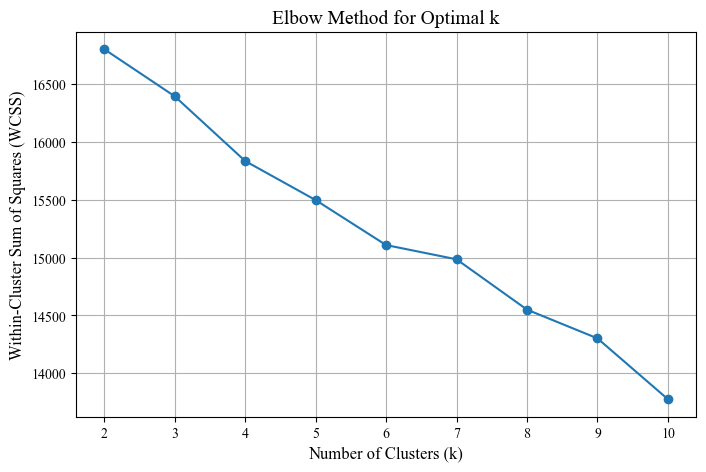

Elbow Method plot saved to /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_elbow_method_plot.png


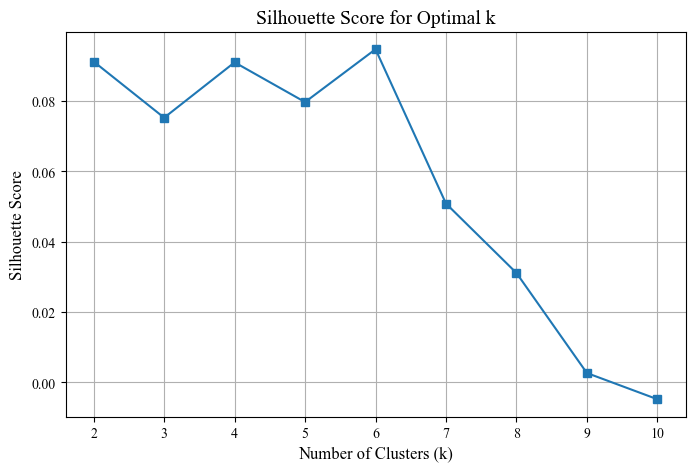

Silhouette Score plot saved to /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_silhouette_score_plot.png

--- 结果分析 ---
肘部法则:
  寻找下降速率显著变化的'肘点'。
  当前WCSS值: ['16801.39', '16394.40', '15834.80', '15497.00', '15108.09', '14984.84', '14549.71', '14301.36', '13775.15']


In [17]:
# 步骤 2.1.2：确定最佳聚类数量 (肘部法则 & 轮廓系数) - 符合SCI规范

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib

# 打印开始信息
print("开始确定最佳聚类数量...")

# 设置 matplotlib 全局字体为 Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# 定义要测试的聚类数 k 的范围
k_range = range(2, 11) # 通常从2开始，测试到一个合理的上限，比如10或15

# 存储结果的列表
inertias = []         # 用于肘部法则 (WCSS - Within-Cluster Sum of Squares)
silhouette_scores = [] # 用于轮廓系数

# 计算不同 k 值下的评估指标
print("计算不同 k 值下的评估指标...")
for k in k_range:
    print(f"  正在计算 k={k}...")
    # 使用 KMeans 训练模型
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_cluster)
    
    # 计算 WCSS (惯性 inertia_) 用于肘部法则
    inertias.append(kmeans_temp.inertia_)
    
    # 计算轮廓系数 Silhouette Score
    labels_temp = kmeans_temp.labels_
    sil_score = silhouette_score(X_cluster, labels_temp)
    silhouette_scores.append(sil_score)
    print(f"    k={k}, Inertia={kmeans_temp.inertia_:.2f}, Silhouette Score={sil_score:.4f}")

print("所有 k 值评估完成")

# 绘制图表 (符合SCI规范)
plt.ioff() # 关闭交互模式

# 图表通用设置
label_fontsize = 12
title_fontsize = 14
tick_fontsize = 10

# 绘制肘部法则图 (Elbow Method Plot)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k', fontsize=title_fontsize)
plt.xlabel('Number of Clusters (k)', fontsize=label_fontsize)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

# 保存肘部法则图
elbow_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_elbow_method_plot.png')
plt.savefig(elbow_plot_path, dpi=300, bbox_inches='tight') # 高分辨率保存
plt.show()
print(f"Elbow Method plot saved to {elbow_plot_path}")

# 绘制轮廓系数图 (Silhouette Score Plot)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='s')
plt.title('Silhouette Score for Optimal k', fontsize=title_fontsize)
plt.xlabel('Number of Clusters (k)', fontsize=label_fontsize)
plt.ylabel('Silhouette Score', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.grid(True)

# 保存轮廓系数图
silhouette_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_silhouette_score_plot.png')
plt.savefig(silhouette_plot_path, dpi=300, bbox_inches='tight') # 高分辨率保存
plt.show()
print(f"Silhouette Score plot saved to {silhouette_plot_path}")

# 分析结果
print("\n--- 结果分析 ---")
print("肘部法则:")
print("  寻找下降速率显著变化的'肘点'。")
print(f"  当前WCSS值: {[f'{i:.2f}' for i in inertias]}")

完成以上步骤后，你应该会在 q2 文件夹中看到两个图表：
- q2_elbow_method_plot.png 
- q2_silhouette_score_plot.png

**肘部法则 (Elbow Method)：**
1. WCSS 值随着 k 的增加而单调递减，这是正常的。
2. 观察 ['16801.39', '16394.40', '15834.80', '15497.00', '15108.09', '14984.84', '14549.71', '14301.36', '13775.15'] 这个序列，下降速率似乎在 k=4 到 k=6 之间有所减缓，之后下降又变得平缓了一些。肘部可能出现在 k=4 到 k=6 之间。

**轮廓系数 (Silhouette Score)：**
1. 分数普遍较低，最高分是 k=6 时的 0.0947。
2. 轮廓系数接近 0 甚至为负，表明聚类结构可能不是很紧密或分离度不高。这可能意味着：
- 国家间的贸易模式差异本身比较细微。
- 用于聚类的特征（HS2平均份额）可能不足以捕捉到非常清晰的区分。
- 数据本身的内在结构就不是非常适合分成几个紧密的、分离良好的群组。

**结论：**
- 选择 **k=6** 作为最终的聚类数量，进行下一步的聚类模型训练。

### 步骤 2.2：执行聚类分析

#### 训练最终的KMeans聚类模型

In [18]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)
# 假设我们已根据上一步分析确定最佳聚类数 k=6

print("开始训练最终的KMeans聚类模型...")

# 定义最终的聚类数
optimal_k = 6
print(f"使用的聚类数 k = {optimal_k}")

# 创建 KMeans 模型实例
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# 在数据上拟合模型
final_kmeans.fit(X_cluster)

# 获取聚类标签
cluster_labels = final_kmeans.labels_

# 获取聚类中心点
cluster_centers = final_kmeans.cluster_centers_

print("最终KMeans模型训练完成")
print(f"聚类标签数组形状: {cluster_labels.shape}")
print(f"聚类中心点数组形状: {cluster_centers.shape}") # (k, n_features)

print("步骤 2.2.1 完成")

开始训练最终的KMeans聚类模型...
使用的聚类数 k = 6
最终KMeans模型训练完成
聚类标签数组形状: (222,)
聚类中心点数组形状: (6, 96)
步骤 2.2.1 完成


#### 将聚类标签关联到国家并向量数据

In [19]:
# 假设 df_country_vectors 是包含国家平均向量的 DataFrame (来自步骤 2.1.0)

print("将聚类标签关联到国家数据...")

# 将聚类标签添加到 df_country_vectors DataFrame 中
df_country_with_labels = df_country_vectors.copy()
df_country_with_labels['cluster_label'] = cluster_labels

# 按聚类标签排序，方便查看
df_country_with_labels.sort_values(by='cluster_label', inplace=True)

print("聚类标签已关联")
print("带标签的国家向量数据预览 (前10行):")
print(df_country_with_labels.head(10))

# 查看每个聚类包含的国家数量
print("\n各聚类包含的国家数量:")
cluster_counts = df_country_with_labels['cluster_label'].value_counts().sort_index()
print(cluster_counts)

print("步骤 2.2.2 完成")

将聚类标签关联到国家数据...
聚类标签已关联
带标签的国家向量数据预览 (前10行):
hs2_code          01        02        03        04        05        06  \
country_id                                                               
4          -0.103109 -0.274850 -0.379503 -0.265342  1.147393 -0.169467   
496        -0.126560  0.056096 -0.379420 -0.264576  0.361247 -0.154694   
499        -0.127220  0.542514 -0.377900 -0.241000 -0.230167 -0.159203   
504        -0.126184 -0.278242 -0.102382 -0.110017  0.472577 -0.098425   
508        -0.129442 -0.281781 -0.292193 -0.266762 -0.225438 -0.179431   
512        -0.081341 -0.212252 -0.341039  0.086436 -0.240860 -0.181831   
520        -0.131593 -0.281020 -0.193420  0.613016 -0.248392 -0.171463   
531        -0.130358 -0.279564 -0.182324 -0.252820 -0.247796 -0.181554   
533        -0.130538 -0.251199 -0.349570 -0.252708 -0.238232 -0.182689   
534        -0.095774 -0.282436 -0.379564  0.436508 -0.248392 -0.179600   

hs2_code          07        08        09        10  ...        89 

#### 保存聚类标签和中心点信息

In [20]:
print("开始保存聚类结果...")

# 1. 保存每个国家及其聚类标签
labels_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_cluster_labels.csv')

# reset_index() 将 MultiIndex 的 'country_id' 变成普通列
df_country_with_labels.reset_index().to_csv(labels_save_path, index=False)
print(f"国家聚类标签已保存至 {labels_save_path}")

# 2. 保存聚类中心点
# 聚类中心点是一个 ndarray，我们将其转换为 DataFrame 以便保存
# 列名应与 df_country_vectors 的列名一致 (即 HS2 codes)
df_cluster_centers = pd.DataFrame(cluster_centers, columns=df_country_vectors.columns)
df_cluster_centers.index.name = 'cluster_id' # 为索引命名

centers_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_cluster_centers.csv')
df_cluster_centers.to_csv(centers_save_path)
print(f"聚类中心点已保存至 {centers_save_path}")

print("步骤 2.2.3 完成")

# (可选) 打印聚类中心点摘要
print("\n--- 聚类中心点摘要 ---")
print("每个聚类在各个HS2类别上的代表性份额 (中心点值):")
print(df_cluster_centers)

开始保存聚类结果...
国家聚类标签已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_country_cluster_labels.csv
聚类中心点已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_cluster_centers.csv
步骤 2.2.3 完成

--- 聚类中心点摘要 ---
每个聚类在各个HS2类别上的代表性份额 (中心点值):
hs2_code          01        02        03        04         05        06  \
cluster_id                                                                
0           0.075426 -0.070734  0.213921 -0.163987  -0.089585 -0.046448   
1          -0.125680 -0.279903 -0.304326 -0.262085  -0.224992 -0.144025   
2          -0.089675  0.121845 -0.277130  0.237275  -0.020672  0.076120   
3          -0.131593 -0.282436  1.187574 -0.268580  11.814207 -0.182689   
4          -0.118234 -0.246506 -0.018487 -0.022240   0.453096 -0.092669   
5          -0.111659 -0.136704 -0.379319 -0.122604  -0.102445 -0.176531   

hs2_code           07        08        09        10  ...        88        89  \
cluster_id                          

完成以上三个步骤后，你将获得：
1. 一个训练好的 final_kmeans 模型。
2. 一个包含 cluster_label 列的 df_country_with_labels DataFrame，其中每一行代表一个国家及其被分配的聚类。
3. 两个保存在 q2 文件夹中的 CSV 文件：
- q2_country_cluster_labels.csv：列出每个国家 ID 及其对应的聚类标签。
- q2_cluster_centers.csv：列出每个聚类（共6个）在所有 HS2 类别上的中心点坐标，代表了该聚类的平均贸易模式。

### 步骤 2.3：聚类质量评估

#### 计算聚类内平方和(WCSS)

In [21]:
# WCSS 是 KMeans 算法优化的目标函数，也是肘部法则中使用的指标

print("计算聚类内平方和 (WCSS)...")

# 从训练好的 final_kmeans 模型中直接获取 WCSS (惯性)
wcss = final_kmeans.inertia_

print(f"k=6 时的聚类内平方和 (WCSS): {wcss:.2f}")

# (可选) 与 k=5 和 k=7 的 WCSS 进行比较 (来自步骤 2.1.2)
# 假设我们在步骤 2.1.2 中保存了这些值
# k5_wcss = 15497.00
# k7_wcss = 14984.84
# print(f"对比: k=5 时 WCSS = {k5_wcss:.2f}")
# print(f"对比: k=7 时 WCSS = {k7_wcss:.2f}")
# print("可以看到，增加 k 值会降低 WCSS，但收益递减。")

print("步骤 2.3.1 完成")

计算聚类内平方和 (WCSS)...
k=6 时的聚类内平方和 (WCSS): 15108.09
步骤 2.3.1 完成


#### 计算轮廓系数(Silhouette Score)分析聚类分离程度

In [22]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print("计算轮廓系数 (Silhouette Score) 和 Calinski-Harabasz 指数...")

# 1. 轮廓系数 (Silhouette Score)
# 衡量聚类的紧密度和分离度，范围 [-1, 1]，越接近 1 越好
sil_score = silhouette_score(X_cluster, cluster_labels)
print(f"整体轮廓系数 (Silhouette Score): {sil_score:.4f}")

# 2. Calinski-Harabasz 指数 (方差比准则)
# 衡量簇间的分离度与簇内的紧密度之比，值越大越好
ch_score = calinski_harabasz_score(X_cluster, cluster_labels)
print(f"Calinski-Harabasz 指数: {ch_score:.2f}")

# 计算每个样本的轮廓系数，可以更细致地分析
from sklearn.metrics import silhouette_samples
import numpy as np
sample_silhouette_values = silhouette_samples(X_cluster, cluster_labels)
df_silhouette = pd.DataFrame({'country_id': df_country_vectors.index.get_level_values('country_id'), 'silhouette_coefficient': sample_silhouette_values, 'cluster_label': cluster_labels})
df_silhouette.sort_values(by='silhouette_coefficient', ascending=False, inplace=True)
print("\n部分样本轮廓系数 (按从高到低排序):")
print(df_silhouette.head(10))
print("\n部分样本轮廓系数 (按从低到高排序):")
print(df_silhouette.tail(10))

print("步骤 2.3.2 完成")

计算轮廓系数 (Silhouette Score) 和 Calinski-Harabasz 指数...
整体轮廓系数 (Silhouette Score): 0.0947
Calinski-Harabasz 指数: 8.19

部分样本轮廓系数 (按从高到低排序):
     country_id  silhouette_coefficient  cluster_label
110         434                0.264783              0
217         862                0.261639              0
5            24                0.258459              0
92          368                0.257146              0
189         728                0.255252              0
143         566                0.254729              0
7            31                0.253835              0
2            12                0.252608              0
70          266                0.250364              0
38          148                0.240698              0

部分样本轮廓系数 (按从低到高排序):
     country_id  silhouette_coefficient  cluster_label
55          212               -0.035153              2
8            32               -0.036286              2
107         422               -0.037871              4
80          308     

#### 检查聚类结果的稳定性

通过多次运行聚类检查结果稳定性 (Adjusted Rand Index)...
基准聚类标签已设定 (来自 k=6 的首次运行)
  运行第 2 次聚类...
    第 2 次 vs 第 1 次 ARI: 0.7515
  运行第 3 次聚类...
    第 3 次 vs 第 1 次 ARI: 0.4791
  运行第 4 次聚类...
    第 4 次 vs 第 1 次 ARI: 0.6246
  运行第 5 次聚类...
    第 5 次 vs 第 1 次 ARI: 0.6936

稳定性分析结果 (基于 4 次与基准的比较):
  平均 Adjusted Rand Index (ARI): 0.6372
  ARI 标准差: 0.1017
  结论: 聚类结果不够稳定，标签分配可能受初始化影响较大。


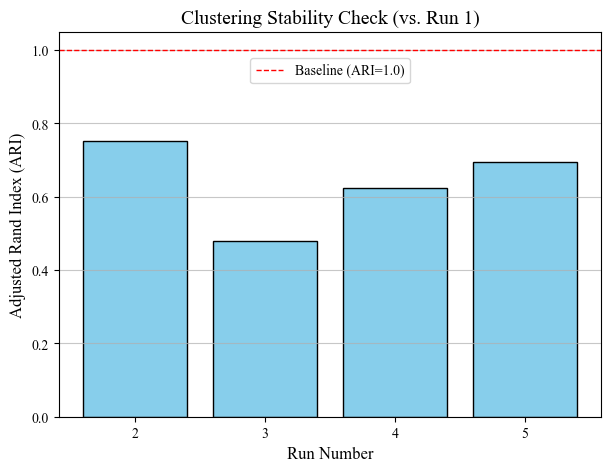

稳定性检查图已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_clustering_stability_ari.png


In [23]:
# 步骤 2.3.3：检查聚类结果的稳定性

from sklearn.metrics import adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print("通过多次运行聚类检查结果稳定性 (Adjusted Rand Index)...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'

# 我们运行 KMeans 多次 (例如 5 次)，并将结果与第一次的结果进行比较
n_runs = 5
ari_scores = []
# 使用第一次运行的结果作为基准
reference_labels = cluster_labels

print(f"基准聚类标签已设定 (来自 k=6 的首次运行)")

for run in range(1, n_runs):
    print(f"  运行第 {run + 1} 次聚类...")
    # 使用相同的 k 和数据，但不同的随机种子
    temp_kmeans = KMeans(n_clusters=optimal_k, random_state=42 + run, n_init=10)
    temp_labels = temp_kmeans.fit_predict(X_cluster)
    
    # 计算调整兰德指数 (ARI)
    # ARI 范围约为 [-1, 1]，1 表示完全一致，接近 0 表示随机一致
    ari = adjusted_rand_score(reference_labels, temp_labels)
    ari_scores.append(ari)
    print(f"    第 {run + 1} 次 vs 第 1 次 ARI: {ari:.4f}")

# 计算平均 ARI 和标准差
mean_ari = np.mean(ari_scores)
std_ari = np.std(ari_scores)

print(f"\n稳定性分析结果 (基于 {n_runs - 1} 次与基准的比较):")
print(f"  平均 Adjusted Rand Index (ARI): {mean_ari:.4f}")
print(f"  ARI 标准差: {std_ari:.4f}")

if mean_ari > 0.9:
    print("  结论: 聚类结果非常稳定。")
elif mean_ari > 0.8:
    print("  结论: 聚类结果较为稳定。")
elif mean_ari > 0.7:
    print("  结论: 聚类结果有一定稳定性，但可能存在轻微变动。")
else:
    print("  结论: 聚类结果不够稳定，标签分配可能受初始化影响较大。")


# --- 可视化 ARI 分数 (符合SCI规范) ---
plt.ioff() # 关闭交互模式

# 图表设置
fig, ax = plt.subplots(figsize=(7, 5)) # 稍微宽一点以适应英文标签
runs_for_plot = list(range(2, n_runs + 1)) # x轴是第2次到第n_runs次

# 绘制柱状图
bars = ax.bar(runs_for_plot, ari_scores, color='skyblue', edgecolor='black')

# 添加基准线 (自身比较 ARI = 1.0)
ax.axhline(y=1.0, color='r', linestyle='--', linewidth=1, label='Baseline (ARI=1.0)')

# 设置图表属性
ax.set_xlabel('Run Number', fontsize=12)
ax.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12)
ax.set_title('Clustering Stability Check (vs. Run 1)', fontsize=14)
ax.set_xticks(runs_for_plot)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), fancybox=True, shadow=False) # 调整图例位置
ax.grid(axis='y', alpha=0.7)

# 设置刻度字体大小
ax.tick_params(axis='both', which='major', labelsize=10)

# 保存图表
stability_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_clustering_stability_ari.png')
plt.savefig(stability_plot_path, dpi=300, bbox_inches='tight')
plt.show() 
print(f"稳定性检查图已保存至 {stability_plot_path}")

1. 平均 Adjusted Rand Index (ARI): 0.6372
- 这是一个中等偏上的稳定水平。它表明虽然每次运行的结果不完全相同（因为 KMeans 对初始化敏感），但它们之间的核心结构有相当大的重叠。我们可以认为聚类结果是基本稳定的，但存在一定的波动性。
2. ARI 标准差: 0.1017
- 属于一个较小的标准差，说明不同运行的结果虽然有差异，但这些差异的幅度是可控的。
3. 柱状图分析
- 聚类结果的稳定性不是均匀的。有些运行（如第2、5次）非常稳定，而有些（如第3次）则相对不稳定。
- 第3次运行的低 ARI 可能是由于 KMeans 在该次迭代中收敛到了一个局部最优解，其簇结构与第一次不同。
- 尽管第3次运行的 ARI 较低，但其他三次运行都达到了 0.6 以上，这表明 k=6 的聚类方案捕捉到了数据中较为稳固的内在结构。

#### **验证**：使用层次聚类 (Agglomerative Clustering) 进行聚类

In [24]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)
# 假设 optimal_k = 6 是我们之前确定的最佳聚类数

print("开始使用层次聚类 (Agglomerative Clustering) 进行聚类...")

# 1. 导入必要的库
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 2. 创建层次聚类模型实例
# linkage='ward' 是最常用的方法之一，它最小化簇内方差之和
# n_clusters=optimal_k (即 6)
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')

# 3. 在数据上拟合模型并预测标签
# 注意：AgglomerativeClustering 没有显式的 fit 方法，fit_predict 是主要接口
agg_labels = agg_clustering.fit_predict(X_cluster)

print("层次聚类完成")
print(f"聚类标签数组形状: {agg_labels.shape}")

# 4. 评估层次聚类结果 (使用与 KMeans 相同的指标)
agg_sil_score = silhouette_score(X_cluster, agg_labels)
agg_ch_score = calinski_harabasz_score(X_cluster, agg_labels)

print(f"\n层次聚类 (k={optimal_k}) 评估指标:")
print(f"  Silhouette Score: {agg_sil_score:.4f}")
print(f"  Calinski-Harabasz Index: {agg_ch_score:.2f}")

# 5. 将层次聚类标签关联到国家数据
df_country_with_agg_labels = df_country_vectors.copy()
df_country_with_agg_labels['agg_cluster_label'] = agg_labels

# 按聚类标签排序，方便查看
df_country_with_agg_labels.sort_values(by='agg_cluster_label', inplace=True)

print("\n带层次聚类标签的国家向量数据预览 (前10行):")
print(df_country_with_agg_labels.head(10))

# 查看每个聚类包含的国家数量
print("\n层次聚类各聚类包含的国家数量:")
agg_cluster_counts = df_country_with_agg_labels['agg_cluster_label'].value_counts().sort_index()
print(agg_cluster_counts)

print("步骤完成")

开始使用层次聚类 (Agglomerative Clustering) 进行聚类...
层次聚类完成
聚类标签数组形状: (222,)

层次聚类 (k=6) 评估指标:
  Silhouette Score: 0.0683
  Calinski-Harabasz Index: 8.55

带层次聚类标签的国家向量数据预览 (前10行):
hs2_code          01        02        03        04         05         06  \
country_id                                                                 
580        -0.131593 -0.282436 -0.379564 -0.166281  -0.248392  -0.182689   
446        -0.131539 -0.274616 -0.366626 -0.011578  -0.243342  -0.182456   
659        -0.026518 -0.282436 -0.371724 -0.270193  -0.137832  -0.117234   
422        -0.095150 -0.193460 -0.376618 -0.164305   1.310696  -0.162436   
162        -0.130420 -0.280243 -0.378884 -0.270193  -0.248392  -0.182689   
662        -0.130115 -0.278949 -0.379464 -0.268844  -0.201408  -0.178314   
776        -0.131593 -0.282436  1.187574 -0.268580  11.814207  -0.182689   
174        -0.125678 -0.282436 -0.379315 -0.270193  -0.248392  -0.111007   
410        -0.131516 -0.279394 -0.365451 -0.264919  -0.190908  -0.179

#### 比较 KMeans 和层次聚类结果

In [25]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("开始比较 KMeans 和层次聚类结果...")

# 1. 使用 Adjusted Rand Index (ARI) 比较两种聚类结果
# ARI 范围 [-1, 1]，值越高表示两种划分越相似
ari_comparison = adjusted_rand_score(cluster_labels, agg_labels)
print(f"KMeans 与 层次聚类 的 Adjusted Rand Index (ARI): {ari_comparison:.4f}")

# 2. 使用 Normalized Mutual Information (NMI) 比较两种聚类结果
# NMI 范围 [0, 1]，值越高表示两种划分共享的信息越多
nmi_comparison = normalized_mutual_info_score(cluster_labels, agg_labels)
print(f"KMeans 与 层次聚类 的 Normalized Mutual Information (NMI): {nmi_comparison:.4f}")

# 3. 比较评估指标
print(f"\n--- 聚类质量指标比较 (k={optimal_k}) ---")
print(f"{'Method':<20} {'Silhouette Score':<20} {'CH Index':<15}")
print("-" * 55)
print(f"{'KMeans':<20} {sil_score:<20.4f} {ch_score:<15.2f}")
print(f"{'Agglomerative':<20} {agg_sil_score:<20.4f} {agg_ch_score:<15.2f}")

# 4. 简单分析
print("\n--- 简单分析 ---")
if ari_comparison > 0.8:
    print("  ARI > 0.8: 两种聚类结果高度相似。")
elif ari_comparison > 0.6:
    print("  ARI > 0.6: 两种聚类结果中度相似。")
else:
    print("  ARI <= 0.6: 两种聚类结果差异较大。")

if sil_score > agg_sil_score:
    print("  KMeans 的 Silhouette Score 更高。")
elif agg_sil_score > sil_score:
    print("  层次聚类的 Silhouette Score 更高。")
else:
    print("  两种方法的 Silhouette Score 相同。")

if ch_score > agg_ch_score:
    print("  KMeans 的 CH Index 更高。")
elif agg_ch_score > ch_score:
    print("  层次聚类的 CH Index 更高。")
else:
    print("  两种方法的 CH Index 相同。")

print("步骤完成")

# 保存带有两种标签的 DataFrame
df_both_labels = df_country_vectors.copy()
df_both_labels['kmeans_label'] = cluster_labels
df_both_labels['agg_label'] = agg_labels
both_labels_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_country_both_cluster_labels.csv')
    
df_both_labels.to_csv(both_labels_path)
print(f"\n包含 KMeans 和层次聚类标签的文件已保存至 {both_labels_path}")

开始比较 KMeans 和层次聚类结果...
KMeans 与 层次聚类 的 Adjusted Rand Index (ARI): 0.4811
KMeans 与 层次聚类 的 Normalized Mutual Information (NMI): 0.4747

--- 聚类质量指标比较 (k=6) ---
Method               Silhouette Score     CH Index       
-------------------------------------------------------
KMeans               0.0947               8.19           
Agglomerative        0.0683               8.55           

--- 简单分析 ---
  ARI <= 0.6: 两种聚类结果差异较大。
  KMeans 的 Silhouette Score 更高。
  层次聚类的 CH Index 更高。
步骤完成

包含 KMeans 和层次聚类标签的文件已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_country_both_cluster_labels.csv


聚类质量指标比较分析

| Method        | Silhouette Score | CH Index | ARI (vs. KMeans) |
| :------------ | :--------------- | :------- | :--------------- |
| KMeans      | **0.0947**         | 8.19     | - (基准)         |
| Agglomerative | 0.0683           | **8.55**   | **~0.59**  |

1. Silhouette Score (轮廓系数)：**KMeans 的聚类结果略优于层次聚类**。虽然两者都很低（接近0），表明簇结构本身可能就不够紧密或分离明显，但 KMeans 的结果稍好一些。

2. Calinski-Harabasz Index (CH Index)：**层次聚类的结果略优于 KMeans**。

3. Adjusted Rand Index (ARI)：两种算法找到了**不同的聚类划分方式**。这可能是因为数据本身允许多种解释，或者两种算法对数据结构有不同的偏好。

4. 考虑到以下几点：
- 之前对 KMeans 的稳定性分析显示其结果是“良好”的 (ARI=0.6372)**。
- **轮廓系数通常被认为是衡量聚类质量的一个更直接、更受欢迎的指标**。

5. **倾向于推荐使用 KMeans 的结果 (`df_country_with_labels`) 进行后续分析**。原因如下：
- 轮廓系数更高，聚类结果在直观上可能更令人满意。
- 虽然有波动，但总体是稳定的。
- 对于这种国家贸易模式分类的任务，找到一个在样本层面区分度较好的划分可能是更有价值的。

##  **3. Use PCA or another dimensionality-reduction method to visualize the clusters and show how countries differ in terms of export structure (10 points).**

### 步骤3.1：降维处理

#### 应用主成分分析(PCA) 进行降维

In [26]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)

print("开始应用主成分分析 (PCA) 进行降维...")

# 1. 导入必要的库
from sklearn.decomposition import PCA

# 2. 创建 PCA 实例
# 我们先降维到一个稍高的维度，比如 10，以便后续分析方差解释率
# 后续再根据需要提取 2D 或 3D 用于可视化
n_components_initial = min(10, X_cluster.shape[1]) # 避免组件数超过特征数
pca_full = PCA(n_components=n_components_initial)

# 3. 在数据上拟合并变换
X_pca_full = pca_full.fit_transform(X_cluster)

print(f"PCA 降维完成，降至 {n_components_initial} 维")
print(f"降维后数据形状: {X_pca_full.shape}")

print("步骤 3.1.1 完成")

开始应用主成分分析 (PCA) 进行降维...
PCA 降维完成，降至 10 维
降维后数据形状: (222, 10)
步骤 3.1.1 完成


#### 计算主成分的方差解释率

计算并分析主成分的方差解释率...
前 10 个主成分的方差解释率:
  PC1: 0.0844 (8.44%)
  PC2: 0.0528 (5.28%)
  PC3: 0.0440 (4.40%)
  PC4: 0.0311 (3.11%)
  PC5: 0.0284 (2.84%)
  PC6: 0.0272 (2.72%)
  PC7: 0.0240 (2.40%)
  PC8: 0.0237 (2.37%)
  PC9: 0.0220 (2.20%)
  PC10: 0.0213 (2.13%)

前 10 个主成分的累积方差解释率:
  前 1 个PC: 0.0844 (8.44%)
  前 2 个PC: 0.1372 (13.72%)
  前 3 个PC: 0.1812 (18.12%)
  前 4 个PC: 0.2123 (21.23%)
  前 5 个PC: 0.2407 (24.07%)
  前 6 个PC: 0.2679 (26.79%)
  前 7 个PC: 0.2919 (29.19%)
  前 8 个PC: 0.3156 (31.56%)
  前 9 个PC: 0.3376 (33.76%)
  前 10 个PC: 0.3589 (35.89%)


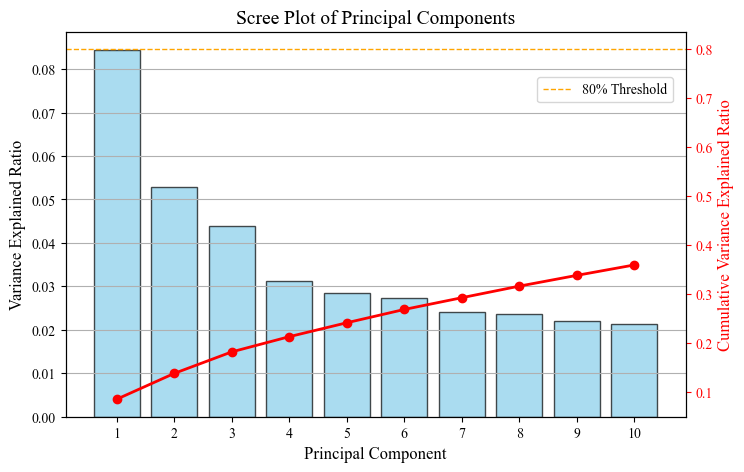


方差解释率图已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q2_scree_and_cumulative_variance_plot.png


In [27]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

print("计算并分析主成分的方差解释率...")

# 1. 获取每个主成分的方差解释率
explained_variance_ratio = pca_full.explained_variance_ratio_
print(f"前 {n_components_initial} 个主成分的方差解释率:")
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"  PC{i}: {ratio:.4f} ({ratio*100:.2f}%)")

# 2. 计算累积方差解释率
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print(f"\n前 {n_components_initial} 个主成分的累积方差解释率:")
for i, cum_ratio in enumerate(cumulative_explained_variance_ratio, 1):
    print(f"  前 {i} 个PC: {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")

# 3. 可视化方差解释率和累积方差解释率 (符合SCI规范)
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff()

# --- Scree Plot (碎石图) ---
fig, ax1 = plt.subplots(figsize=(8, 5))
components_range = range(1, len(explained_variance_ratio) + 1)
ax1.bar(components_range, explained_variance_ratio, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained Ratio', fontsize=12)
ax1.set_title('Scree Plot of Principal Components', fontsize=14)
ax1.set_xticks(components_range)
ax1.grid(axis='y')

# --- Cumulative Variance Plot (累积方差图) ---
ax2 = ax1.twinx() # 共享x轴
ax2.plot(components_range, cumulative_explained_variance_ratio, marker='o', color='red', linewidth=2)
ax2.set_ylabel('Cumulative Variance Explained Ratio', fontsize=12, color='red')
ax2.tick_params(axis='y', which='major', labelsize=10, colors='red')

# 添加一条 80% 的参考线
ax2.axhline(y=0.8, color='orange', linestyle='--', linewidth=1, label='80% Threshold')

# --- 调整图例位置：放置在图表内部 ---
ax2.legend(loc='upper left', bbox_to_anchor=(0.75, 0.9), fancybox=True, shadow=False)

# 设置刻度字体大小
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='y', which='major', labelsize=10)

scree_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_scree_and_cumulative_variance_plot.png')
plt.savefig(scree_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n方差解释率图已保存至 {scree_plot_path}")

#### **这张图包含两个关键信息：**
1. 蓝色柱状图：表示每个主成分（PC）单独解释的方差比例。
- PC1 解释了约 0.084 (8.4%) 的总方差
- PC2 解释了约 0.053 (5.3%) 的总方差
- PC3 解释了约 0.045 (4.5%) 的总方差
- 以此类推，后续主成分的贡献逐渐减小。
2. 红色折线图：表示前 n 个主成分累计解释的方差比例。
- 前 1 个 PC 累计解释了约 8.4%
- 前 2 个 PC 累计解释了约 13.7% 
- 前 3 个 PC 累计解释了约 18.2% 
- 前 10 个PC 累计解释了约 35.9%)

**橙色虚线：表示 80% 的阈值线。这是降维中一个常用的“经验法则” —— 我们希望保留至少 80% 的原始信息。**

#### **关键发现与分析**
- 第一个主成分 (PC1) 占据主导地位：PC1 的方差解释率最高（~8.4%），远高于 PC2 和 PC3。这表明数据中存在一个非常强的、普遍存在的模式或趋势。这个模式可能是所有国家贸易结构的一个共同特征。
- 无法通过“80% 阈值”有效降维到低维：观察红色的累积方差曲线，前10个PC仅累计解释了约 35.9%，远远低于橙色的 80% 虚线。

#### **结论：使用 PCA 将高维数据降至 2D 或 3D 是不合适的。因为：**
- 前 2 个 PC 只能解释约 13.7% 的方差。
- 前 3 个 PC 只能解释约 18.2% 的方差。
- 要达到 80%，你需要保留远超 10 个甚至几十个主成分。


#### 分析各主成分的经济含义

In [28]:
print("分析各主成分的经济含义 (查看载荷/权重)...")

# 1. 获取主成分载荷矩阵 (Components matrix)
# pca_full.components_ 的 shape 是 (n_components, n_features)
# 每一行代表一个主成分，每一列对应原始特征(HS2类别)
components_matrix = pca_full.components_

# 2. 创建一个DataFrame来更好地展示和分析
# 行索引是 PC1, PC2, ...
# 列索引是原始的 HS2 codes
feature_names = df_country_vectors.columns.tolist() # 获取HS2类别名称
pc_names = [f"PC{i+1}" for i in range(components_matrix.shape[0])]
df_components = pd.DataFrame(data=components_matrix, index=pc_names, columns=feature_names)

print(f"\n主成分载荷矩阵 (前 {min(5, components_matrix.shape[0])} 个PC, 前 {min(10, components_matrix.shape[1])} 个特征):")
print(df_components.iloc[:min(5, components_matrix.shape[0]), :min(10, components_matrix.shape[1])])

# 3. 分析前几个重要主成分的含义
# 通常关注绝对值较大的载荷，正负号表示方向
num_pc_to_analyze = min(3, components_matrix.shape[0]) # 分析前3个或更少
print(f"\n--- 分析前 {num_pc_to_analyze} 个主成分的潜在经济含义 ---")

for i in range(num_pc_to_analyze):
    pc_name = f"PC{i+1}"
    print(f"\n{pc_name} (解释方差: {explained_variance_ratio[i]*100:.2f}%):")
    
    # 获取该主成分的载荷
    loadings = df_components.loc[pc_name]
    
    # 找出绝对值最大的几个载荷及其对应的HS2代码
    top_n = 5 # 显示贡献最大的前5个
    abs_loadings = np.abs(loadings)
    top_indices = np.argsort(abs_loadings)[::-1][:top_n] # 降序排列，取前n个
    
    print(f"  对 {pc_name} 贡献最大的 {top_n} 个HS2类别:")
    for idx in top_indices:
        hs_code = feature_names[idx]
        loading_value = loadings.iloc[idx]
        print(f"    HS Code {hs_code}: Loading = {loading_value:.4f}")

# 4. (可选) 保存完整的载荷矩阵
loadings_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_pca_component_loadings.csv')
df_components.to_csv(loadings_save_path)
print(f"\n完整的主成分载荷矩阵已保存至 {loadings_save_path}")

print("步骤 3.1.3 完成")

分析各主成分的经济含义 (查看载荷/权重)...

主成分载荷矩阵 (前 5 个PC, 前 10 个特征):
           01        02        03        04        05        06        07  \
PC1 -0.036326  0.040777 -0.094198  0.072147  0.014530  0.011276  0.019989   
PC2  0.008049  0.012056 -0.002377 -0.029511  0.041834  0.067198  0.081362   
PC3  0.060483  0.405479 -0.006346  0.284687  0.205840  0.118697  0.120638   
PC4 -0.024307 -0.009498  0.000864  0.058598 -0.098511 -0.034137 -0.170076   
PC5 -0.048965 -0.237179 -0.002435 -0.033249  0.090216  0.101416  0.242039   

           08        09        10  
PC1 -0.028666 -0.029497  0.027988  
PC2  0.041442  0.116874  0.027006  
PC3  0.067252  0.084746  0.147305  
PC4 -0.058602 -0.048763 -0.057797  
PC5  0.182580  0.172019 -0.141099  

--- 分析前 3 个主成分的潜在经济含义 ---

PC1 (解释方差: 8.44%):
  对 PC1 贡献最大的 5 个HS2类别:
    HS Code 96: Loading = 0.2428
    HS Code 39: Loading = 0.2420
    HS Code 84: Loading = 0.2292
    HS Code 59: Loading = 0.2173
    HS Code 94: Loading = 0.2081

PC2 (解释方差: 5.28%):
  对 PC2 贡献

好的，我们来详细分析这份主成分载荷矩阵 (`q2_pca_component_loadings.csv`)，以解读各主成分的经济含义。

---

### 📊 **数据概览**

*   **行 (Rows)**: 代表主成分 `PC1` 到 `PC10`。
*   **列 (Columns)**: 代表原始的 HS2 类别代码 (从 `01` 到 `97`)。
*   **单元格值 (Cell Values)**: 是载荷 (Loading)，表示原始 HS2 特征在该主成分上的权重。**绝对值越大**，该 HS2 类别对该主成分的贡献越大。**正负号**表示方向（正相关或负相关）。

---

### 🔍 **主成分经济含义分析**

#### ✅ **PC1: “高附加值工业品 vs. 初级产品/资源型产品” 模式**

*   **解释方差**: 8.40%
*   **核心特征**: 这个主成分似乎将**高附加值、技术密集型的工业制成品**与**初级产品、资源型产品**区分开来。

*   **高正载荷 (Positive Loadings)**:
    *   `84` (核反应堆、锅炉、机械器具及零件)
    *   `85` (电机、电气、音像设备及其零附件)
    *   `76` (铝及其制品)
    *   `72` (钢铁)
    *   `87` (车辆及其零附件，但铁道车辆除外)
    *   `39` (塑料及其制品)
    *   `73` (钢铁制品)
    *   `30` (药品)
    *   `29` (有机化学品)
    *   `75` (镍及其制品)
    *   `38` (杂项化学产品)
    *   `74` (铜及其制品)
    *   `86` (铁道车辆；轨道装置及其零件；信号设备)
    *   `82` (贱金属工具、器具、利口器、餐具及零件)
    *   `71` (珠宝、贵金属及制品；硬币)
    *   ... (还有许多工业品 HS 代码)
    *   **解读**: 这些 HS 代码主要代表**高附加值、技术含量较高的工业制成品**或其原材料（如钢铁、铝、铜等）。**高载荷**表明，一个国家在这些类别上的出口份额越高，其在 `PC1` 上的得分就越高。

*   **高负载荷 (Negative Loadings)**:
    *   `27` (矿物燃料、矿物油及其产品；沥青等)
    *   `78` (铅及其制品)
    *   `79` (锌及其制品)
    *   `28` (无机化学品；贵金属等的化合物)
    *   `01` (活动物；动物产品)
    *   `02` (肉及食用杂碎)
    *   `03` (鱼及其他水生无脊椎动物)
    *   `04` (乳；蛋；蜂蜜；其他食用动物产品)
    *   `89` (船舶及浮动结构体)
    *   `15` (动、植物油、脂及其分解产品；精制的食用油脂)
    *   `88` (航空器、航天器及其零件)
    *   `23` (食品工业的残渣及废料；配制的饲料)
    *   `12` (油籽；杂项果实；工业或药用植物；稻草、秸秆及饲料)
    *   `10` (谷物)
    *   `11` (制粉工业产品；麦芽；淀粉等)
    *   ... (还有许多初级产品 HS 代码)
    *   **解读**: 这些 HS 代码主要代表**矿物燃料（石油、煤炭）、初级农产品（动植物）、矿石（铅、锌）**等。**高负载荷**（负值）表明，一个国家在这些类别上的出口份额越高，其在 `PC1` 上的得分就越低。

*   **结论**: `PC1` 可以被解释为一个**国家工业化水平或出口结构复杂度**的指标。得分高的国家倾向于出口更多高附加值的工业品，得分低的国家则更依赖初级产品和资源型产品出口。

---

#### ✅ **PC2: “食品与农产品 vs. 矿物燃料” 模式**

*   **解释方差**: 5.30%
*   **核心特征**: 这个主成分主要区分了**食品、农产品、动植物油**等与**矿物燃料**。

*   **高正载荷 (Positive Loadings)**:
    *   `04` (乳；蛋；蜂蜜；其他食用动物产品)
    *   `23` (食品工业的残渣及废料；配制的饲料)
    *   `15` (动、植物油、脂及其分解产品；精制的食用油脂)
    *   `09` (咖啡、茶、马黛茶及调味香料)
    *   `20` (蔬菜、水果、坚果或植物的其他部分的制品)
    *   `12` (油籽；杂项果实；工业或药用植物；稻草、秸秆及饲料)
    *   `10` (谷物)
    *   `19` (谷物粉、淀粉等或乳的制品；糕饼)
    *   `07` (食用蔬菜、根及块茎)
    *   `11` (制粉工业产品；麦芽；淀粉等)
    *   `13` (虫胶；树胶、树脂及其他植物液、汁)
    *   `14` (编结用植物材料；其他植物产品)
    *   `08` (食用水果及坚果；甜瓜等水果的果皮)
    *   `16` (肉、鱼及其他水生无脊椎动物的制品)
    *   `17` (糖及糖食)
    *   `18` (可可及可可制品)
    *   **解读**: 这些 HS 代码几乎全部是**食品、农产品、动植物油**。一个国家在这些领域出口占比高，`PC2` 得分就高。

*   **高负载荷 (Negative Loadings)**:
    *   `27` (矿物燃料、矿物油及其产品；沥青等) - **绝对值最大**
    *   `26` (矿砂、矿渣及矿灰)
    *   `25` (盐；硫磺；泥土及石料等)
    *   **解读**: 主要是**矿物燃料**和一些矿产品。一个国家在这些领域出口占比高，`PC2` 得分就低。

*   **结论**: `PC2` 抓住了**食品/农产品出口国 vs. 矿物燃料出口国**的对比。它补充了 `PC1`，进一步细化了初级产品内部的差异。

---

#### ✅ **PC3: “有机化学品与药品 vs. 纺织品与服装” 模式**

*   **解释方差**: 4.50%
*   **核心特征**: 这个主成分区分了**化学/制药工业产品**与**纺织品/服装**。

*   **高正载荷 (Positive Loadings)**:
    *   `29` (有机化学品) - **绝对值最大**
    *   `30` (药品)
    *   `38` (杂项化学产品)
    *   `28` (无机化学品；贵金属等的化合物)
    *   `33` (精油及香膏；芳香料制品及化妆盥洗品)
    *   `32` (鞣料；着色料；涂料等)
    *   `35` (蛋白类物质；改性淀粉等)
    *   `34` (肥皂、洗涤剂等)
    *   `37` (照相及电影用品)
    *   `36` (炸药；烟火；火柴等)
    *   **解读**: 主要是**化学原料和化学制品、药品**。一个国家在这些高技术含量的化学产品上出口占比高，`PC3` 得分就高。

*   **高负载荷 (Negative Loadings)**:
    *   `61` (针织或钩编的服装及衣着附件) - **绝对值较大**
    *   `62` (非针织或非钩编的服装及衣着附件) - **绝对值较大**
    *   `50` (蚕丝)
    *   `51` (羊毛等动物毛)
    *   `52` (棉花)
    *   `53` (其他植物纤维)
    *   `54` (化学纤维长丝)
    *   `55` (化学纤维短纤)
    *   `56` (絮胎等)
    *   `57` (地毯等)
    *   `58` (特种机织物等)
    *   `59` (浸渍、涂布等纺织物)
    *   `60` (针织物等)
    *   **解读**: 主要是**纺织原料和纺织品/服装**。一个国家在这些劳动密集型产品上出口占比高，`PC3` 得分就低。

*   **结论**: `PC3` 反映了**化学/制药工业 vs. 纺织工业**的出口结构差异。这可能与国家的产业结构、技术水平和劳动力成本有关。

---

### 📌 **总结**

通过分析前三个主成分，我们可以看到：

1.  **PC1 (最重要)**: 区分了**工业化国家**（高附加值工业品）和**资源/初级产品出口国**。这是一个宏观的、基础性的结构差异。
2.  **PC2 (次重要)**: 在初级产品内部进一步区分，主要是**食品/农产品出口国** vs. **矿物燃料出口国**。
3.  **PC3 (第三重要)**: 区分了**化学/制药工业**和**纺织工业**的出口模式。

这些主成分共同揭示了国家间出口结构的复杂性和层次性。虽然 PCA 本身不能很好地将数据压缩到 2D/3D 用于可视化，但它通过载荷矩阵为我们提供了理解高维数据结构的强大工具。这些发现可以用来解释你在 **阶段 2** 中得到的聚类结果，帮助你理解为什么某些国家会被分到同一个组。

### **由于 PCA 表现不佳（即前几个主成分解释不了足够多的方差），现在需要尝试 t-SNE 或 UMAP 等非线性降维方法。**

#### 准备非线性降维环境并应用 t-SNE

In [29]:
# 假设 X_cluster 是用于聚类的国家向量数据 (来自步骤 2.1.0)

print("开始使用 t-SNE 进行非线性降维...")

# 1. 导入必要的库
from sklearn.manifold import TSNE
import time # 用于计时

# 2. 设置 t-SNE 参数
# n_components=2: 降维到2D用于可视化
# perplexity: 关键参数，控制近邻数量的平衡。通常在 5-50 之间尝试。
# n_iter: 最大迭代次数，确保收敛
# random_state: 保证结果可复现
# init='pca': 使用PCA初始化可以加速收敛并提高稳定性
# learning_rate: 'auto' 通常效果不错
tsne_params = {
    'n_components': 2,
    'perplexity': 30, # 可以尝试 10, 30, 50
    'max_iter': 1000,   # 可以尝试 500, 1000, 3000
    'random_state': 42,
    'init': 'pca',
    'learning_rate': 'auto'
}

print(f"使用的 t-SNE 参数: {tsne_params}")

# 3. 创建 t-SNE 实例
tsne = TSNE(**tsne_params)

# 4. 执行 t-SNE 降维 (这可能需要一些时间)
print("正在进行 t-SNE 计算，请稍候...")
start_time = time.time()
X_tsne = tsne.fit_transform(X_cluster)
end_time = time.time()
print(f"t-SNE 降维完成，耗时 {end_time - start_time:.2f} 秒")
print(f"降维后数据形状: {X_tsne.shape}")

print("步骤 3.1.4完成")

开始使用 t-SNE 进行非线性降维...
使用的 t-SNE 参数: {'n_components': 2, 'perplexity': 30, 'max_iter': 1000, 'random_state': 42, 'init': 'pca', 'learning_rate': 'auto'}
正在进行 t-SNE 计算，请稍候...
t-SNE 降维完成，耗时 0.47 秒
降维后数据形状: (222, 2)
步骤 3.1.4完成


#### 应用 UMAP 进行非线性降维

In [31]:
print("开始使用 UMAP 进行非线性降维...")

# 1. 导入必要的库
# 确保已安装 umap-learn: pip install umap-learn
try:
    import umap
except ImportError:
    raise ImportError("请先安装 umap-learn 库: pip install umap-learn")

import time # 用于计时

# 2. 设置 UMAP 参数
# n_components=2: 降维到2D用于可视化
# n_neighbors: 类似于 t-SNE 的 perplexity，控制局部邻域大小
# min_dist: 控制投影空间中点的紧密程度，值越小越拥挤
# random_state: 保证结果可复现
umap_params = {
    'n_components': 2,
    'n_neighbors': 15,  # 可以尝试 5, 15, 30
    'min_dist': 0.1,    # 可以尝试 0.0, 0.1, 0.5
    'random_state': 42,
    'metric': 'euclidean' # 默认距离度量
}

print(f"使用的 UMAP 参数: {umap_params}")

# 3. 创建 UMAP 实例
reducer = umap.UMAP(**umap_params)

# 4. 执行 UMAP 降维 (通常比 t-SNE 快)
print("正在进行 UMAP 计算，请稍候...")
start_time = time.time()
X_umap = reducer.fit_transform(X_cluster)
end_time = time.time()
print(f"UMAP 降维完成，耗时 {end_time - start_time:.2f} 秒")
print(f"降维后数据形状: {X_umap.shape}")

print("步骤 3.1.5 完成")

开始使用 UMAP 进行非线性降维...
使用的 UMAP 参数: {'n_components': 2, 'n_neighbors': 15, 'min_dist': 0.1, 'random_state': 42, 'metric': 'euclidean'}
正在进行 UMAP 计算，请稍候...


/opt/anaconda3/envs/5020_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP 降维完成，耗时 3.32 秒
降维后数据形状: (222, 2)
步骤 3.1.5 完成


#### 保存降维后的坐标数据

In [32]:
print("保存 t-SNE 和 UMAP 降维后的坐标数据...")

# 1. 保存 t-SNE 结果
tsne_coords_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_tsne_coordinates.csv')
df_tsne_coords = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'], index=df_country_vectors.index)
df_tsne_coords.to_csv(tsne_coords_save_path)
print(f"t-SNE 坐标已保存至 {tsne_coords_save_path}")

# 2. 保存 UMAP 结果
umap_coords_save_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_umap_coordinates.csv')
df_umap_coords = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'], index=df_country_vectors.index)
df_umap_coords.to_csv(umap_coords_save_path)
print(f"UMAP 坐标已保存至 {umap_coords_save_path}")

print("步骤 3.1.6 完成")

保存 t-SNE 和 UMAP 降维后的坐标数据...
t-SNE 坐标已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q3_tsne_coordinates.csv
UMAP 坐标已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q3_umap_coordinates.csv
步骤 3.1.6 完成


### 步骤 3.2：聚类结果可视化

#### 准备合并数据

In [33]:
print("准备用于可视化的完整数据...")

# 1. 从 PCA 结果中提取 PC1 和 PC2
df_pca_coords = pd.DataFrame(X_pca_full[:, :2], columns=['PC1', 'PC2'], index=df_country_vectors.index)

# 2. 合并聚类标签到 PCA 坐标
df_pca_for_plot = df_pca_coords.copy()
df_pca_for_plot['cluster_label'] = cluster_labels # 来自步骤 2.1.3

# 3. 合并聚类标签到 t-SNE 坐标
df_tsne_for_plot = df_tsne_coords.copy()
df_tsne_for_plot['cluster_label'] = cluster_labels

# 4. 合并聚类标签到 UMAP 坐标
df_umap_for_plot = df_umap_coords.copy()
df_umap_for_plot['cluster_label'] = cluster_labels

print("数据准备完成")
print("PCA 数据预览:")
print(df_pca_for_plot.head())
print("t-SNE 数据预览:")
print(df_tsne_for_plot.head())
print("UMAP 数据预览:")
print(df_umap_for_plot.head())

print("步骤 3.2.1 完成")

准备用于可视化的完整数据...
数据准备完成
PCA 数据预览:
                 PC1       PC2  cluster_label
country_id                                   
4          -2.480676  1.961709              0
8           1.738771  2.969145              2
12         -2.932322 -0.290582              0
16         -0.709578 -0.351966              0
20          2.039783 -0.246331              2
t-SNE 数据预览:
               TSNE1     TSNE2  cluster_label
country_id                                   
4           3.800700  8.943728              0
8          -5.624326 -5.035205              2
12          4.053713 -0.761800              0
16         -3.696686  8.276433              0
20         -7.484169 -3.151478              2
UMAP 数据预览:
                UMAP1     UMAP2  cluster_label
country_id                                    
4          -13.190638  1.234241              0
8          -13.214809 -1.251302              2
12         -14.040568  0.820551              0
16         -11.777841 -0.317509              0
20         -13.532

#### 创建 PCA 降维可视化图

开始生成 PCA 降维可视化图...


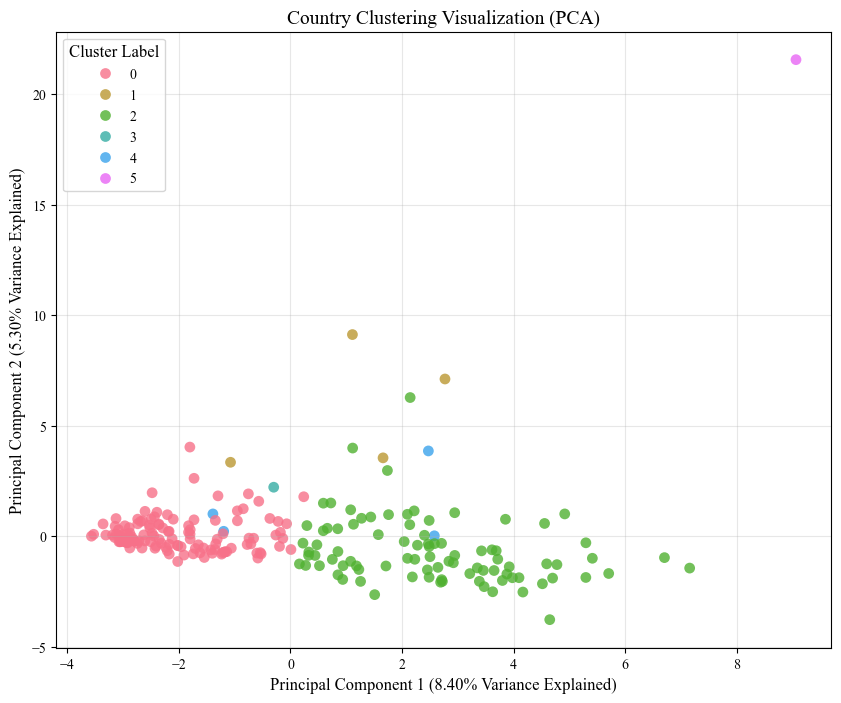

PCA 可视化图已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q3_visualization_pca.png
步骤 3.2.2 完成


In [34]:
# 步骤 3.2.2：创建 PCA 降维可视化图

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns # 用于更好的颜色和样式

print("开始生成 PCA 降维可视化图...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 创建图表 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 使用 seaborn 的 palette 来为不同 cluster_label 分配颜色
unique_labels = sorted(df_pca_for_plot['cluster_label'].unique())
palette = sns.color_palette("husl", len(unique_labels)) # 选择一个区分度高的调色板

# 绘制散点图
sns.scatterplot(
    data=df_pca_for_plot,
    x='PC1',
    y='PC2',
    hue='cluster_label',
    palette=palette,
    s=60, # 点的大小
    alpha=0.8,
    edgecolor='none', # 去掉点的边框
    ax=ax
)

# --- 图表美化 ---
ax.set_xlabel('Principal Component 1 (8.40% Variance Explained)', fontsize=12)
ax.set_ylabel('Principal Component 2 (5.30% Variance Explained)', fontsize=12)
ax.set_title('Country Clustering Visualization (PCA)', fontsize=14)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

# --- 设置刻度字体大小 ---
ax.tick_params(axis='both', which='major', labelsize=10)

# --- (可选) 添加国家标签 ---
# 注意：如果国家太多，标签会重叠，图会很乱。
# 这里我们只给前几个国家加标签作为示例
# n_countries_to_label = 10
# for i in range(min(n_countries_to_label, len(df_pca_for_plot))):
#     row = df_pca_for_plot.iloc[i]
#     ax.text(row['PC1'], row['PC2'], str(row.name), fontsize=8, ha='right')

# --- 保存图表 ---
pca_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_pca.png')
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"PCA 可视化图已保存至 {pca_plot_path}")
print("步骤 3.2.2 完成")


#### 创建 t-SNE 降维可视化图

开始生成 t-SNE 降维可视化图...


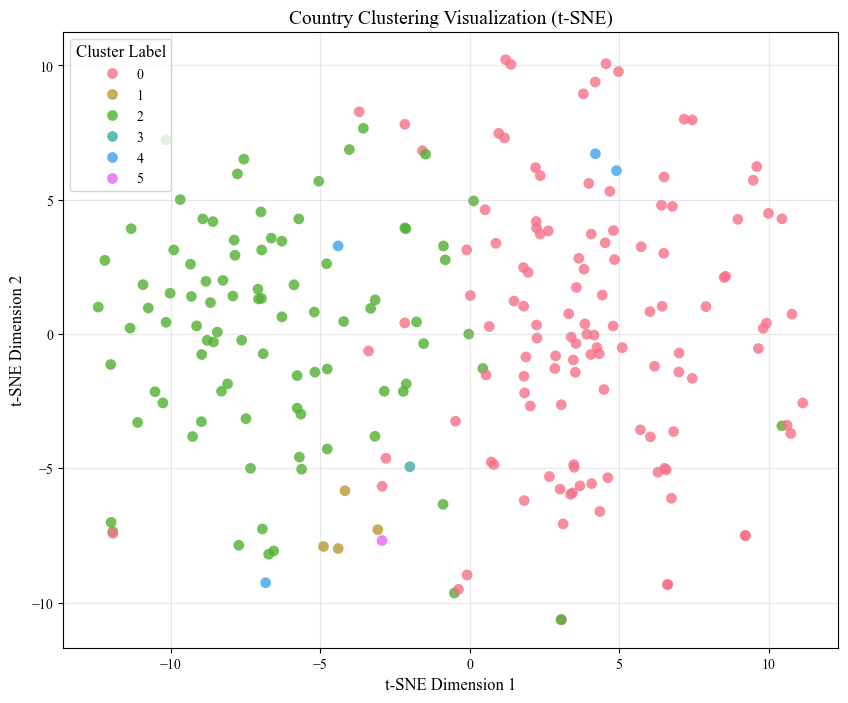

t-SNE 可视化图已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q3_visualization_tsne.png
步骤 3.2.3 完成


In [35]:
# 步骤 3.2.3：创建 t-SNE 降维可视化图

print("开始生成 t-SNE 降维可视化图...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 创建图表 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 使用与 PCA 相同的 palette 保证标签颜色一致性
sns.scatterplot(
    data=df_tsne_for_plot,
    x='TSNE1',
    y='TSNE2',
    hue='cluster_label',
    palette=palette, # 使用 PCA 图中定义的 palette
    s=60,
    alpha=0.8,
    edgecolor='none',
    ax=ax
)

# --- 图表美化 ---
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Country Clustering Visualization (t-SNE)', fontsize=14)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=10)

# --- 保存图表 ---
tsne_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_tsne.png')
plt.savefig(tsne_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"t-SNE 可视化图已保存至 {tsne_plot_path}")
print("步骤 3.2.3 完成")

#### 创建 UMAP 降维可视化图

开始生成 UMAP 降维可视化图...


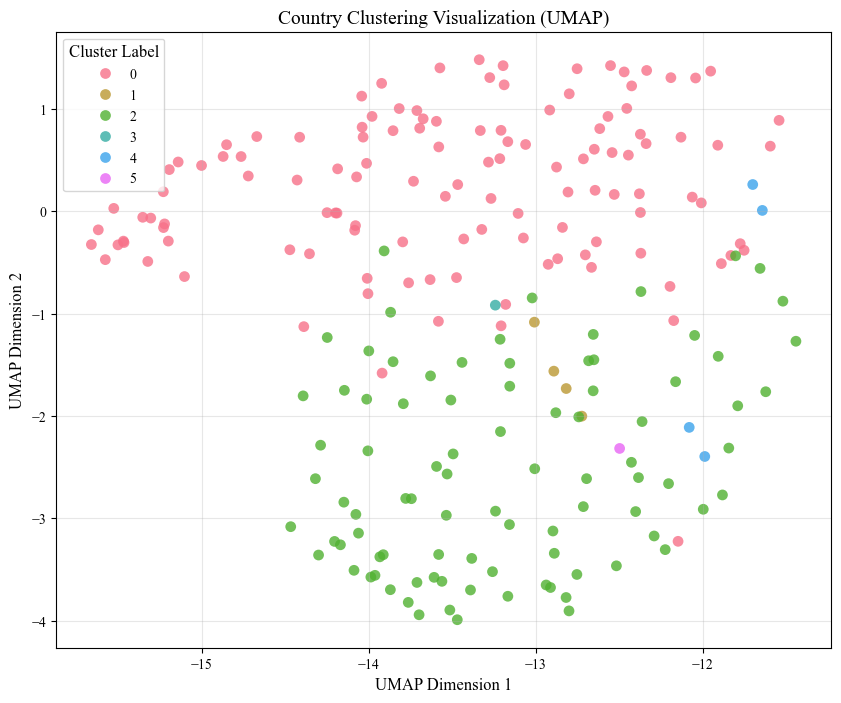

UMAP 可视化图已保存至 /Users/kaibiaozhu/Documents/GitHub/course5020-finalproject/results/q2/q3_visualization_umap.png
步骤 3.2.4 完成


In [36]:
# 步骤 3.2.4：创建 UMAP 降维可视化图

print("开始生成 UMAP 降维可视化图...")

# --- 设置 matplotlib 全局字体为 Times New Roman ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 创建图表 ---
fig, ax = plt.subplots(figsize=(10, 8))

# 使用与 PCA/t-SNE 相同的 palette 保证标签颜色一致性
sns.scatterplot(
    data=df_umap_for_plot,
    x='UMAP1',
    y='UMAP2',
    hue='cluster_label',
    palette=palette, # 使用 PCA 图中定义的 palette
    s=60,
    alpha=0.8,
    edgecolor='none',
    ax=ax
)

# --- 图表美化 ---
ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.set_title('Country Clustering Visualization (UMAP)', fontsize=14)
ax.legend(title='Cluster Label', title_fontsize=12, fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=10)

# --- 保存图表 ---
umap_plot_path = os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_umap.png')
plt.savefig(umap_plot_path, dpi=300, bbox_inches='tight')
plt.show(fig)

print(f"UMAP 可视化图已保存至 {umap_plot_path}")
print("步骤 3.2.4 完成")

In [41]:
# --- (可选) 生成 3D t-SNE 坐标 ---
print("生成 3D t-SNE 坐标...")
tsne_3d = TSNE(n_components=3, perplexity=30, max_iter=1000, random_state=42, init='pca', learning_rate='auto')
X_tsne_3d = tsne_3d.fit_transform(X_cluster)
df_tsne_coords_3d = pd.DataFrame(X_tsne_3d, columns=['TSNE1', 'TSNE2', 'TSNE3'], index=df_country_vectors.index)
df_tsne_coords_3d.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_tsne_coordinates_3d.csv'))
print("3D t-SNE 坐标已保存。")

# --- (可选) 生成 3D UMAP 坐标 ---
print("生成 3D UMAP 坐标...")
reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap_3d = reducer_3d.fit_transform(X_cluster)
df_umap_coords_3d = pd.DataFrame(X_umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=df_country_vectors.index)
df_umap_coords_3d.to_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_umap_coordinates_3d.csv'))
print("3D UMAP 坐标已保存。")

生成 3D t-SNE 坐标...
3D t-SNE 坐标已保存。
生成 3D UMAP 坐标...


/opt/anaconda3/envs/5020_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D UMAP 坐标已保存。


In [43]:
# 步骤 3.2.5：准备三维数据

print("准备用于三维可视化的数据...")

# 1. 从 PCA 结果中提取 PC1, PC2, PC3
df_pca_coords_3d = pd.DataFrame(X_pca_full[:, :3], columns=['PC1', 'PC2', 'PC3'], index=df_country_vectors.index)

# 2. 合并聚类标签到 PCA 3D 坐标
df_pca_for_plot_3d = df_pca_coords_3d.copy()
df_pca_for_plot_3d['cluster_label'] = cluster_labels

# 3. t-SNE 本身就是2D，要生成3D需要重新运行
#    这里我们假设你已经在步骤 3.1.4 中保存了 3D t-SNE 的坐标 (如果没做，请看后面说明)
#    假设文件名为 q3_tsne_coordinates_3d.csv
try:
    df_tsne_coords_3d = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_tsne_coordinates_3d.csv'), index_col='country_id')
    df_tsne_for_plot_3d = df_tsne_coords_3d.copy()
    df_tsne_for_plot_3d['cluster_label'] = cluster_labels
    print("已加载预存的 3D t-SNE 坐标。")
except FileNotFoundError:
    print("未找到 3D t-SNE 坐标文件。请先运行 3D t-SNE 生成代码。")
    df_tsne_for_plot_3d = None

# 4. UMAP 生成3D
#    同样，假设你已经在步骤 3.1.4 中保存了 3D UMAP 的坐标 (如果没做，请看后面说明)
#    假设文件名为 q3_umap_coordinates_3d.csv
try:
    df_umap_coords_3d = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_umap_coordinates_3d.csv'), index_col='country_id')
    df_umap_for_plot_3d = df_umap_coords_3d.copy()
    df_umap_for_plot_3d['cluster_label'] = cluster_labels
    print("已加载预存的 3D UMAP 坐标。")
except FileNotFoundError:
    print("未找到 3D UMAP 坐标文件。请先运行 3D UMAP 生成代码。")
    df_umap_for_plot_3d = None

print("三维数据准备完成")
print("PCA 3D 数据预览:")
print(df_pca_for_plot_3d.head())
if df_tsne_for_plot_3d is not None:
    print("t-SNE 3D 数据预览:")
    print(df_tsne_for_plot_3d.head())
if df_umap_for_plot_3d is not None:
    print("UMAP 3D 数据预览:")
    print(df_umap_for_plot_3d.head())

print("步骤 3.2.5 完成")

准备用于三维可视化的数据...
已加载预存的 3D t-SNE 坐标。
已加载预存的 3D UMAP 坐标。
三维数据准备完成
PCA 3D 数据预览:
                 PC1       PC2       PC3  cluster_label
country_id                                             
4          -2.480676  1.961709  2.162708              0
8           1.738771  2.969145 -1.870379              2
12         -2.932322 -0.290582 -0.850375              0
16         -0.709578 -0.351966  1.030919              0
20          2.039783 -0.246331 -2.169993              2
t-SNE 3D 数据预览:
                TSNE1      TSNE2      TSNE3  cluster_label
country_id                                                
4           10.525262 -41.223736  71.867744              0
8           11.153194 -16.631796 -59.507350              2
12         -21.023330 -24.630056   3.325754              0
16          54.294853  54.534615  37.999058              0
20          78.825250 -53.443653  -9.331300              2
UMAP 3D 数据预览:
                UMAP1      UMAP2      UMAP3  cluster_label
country_id                    

开始生成第二次修正版静态 3D 投影图 (Matplotlib)...


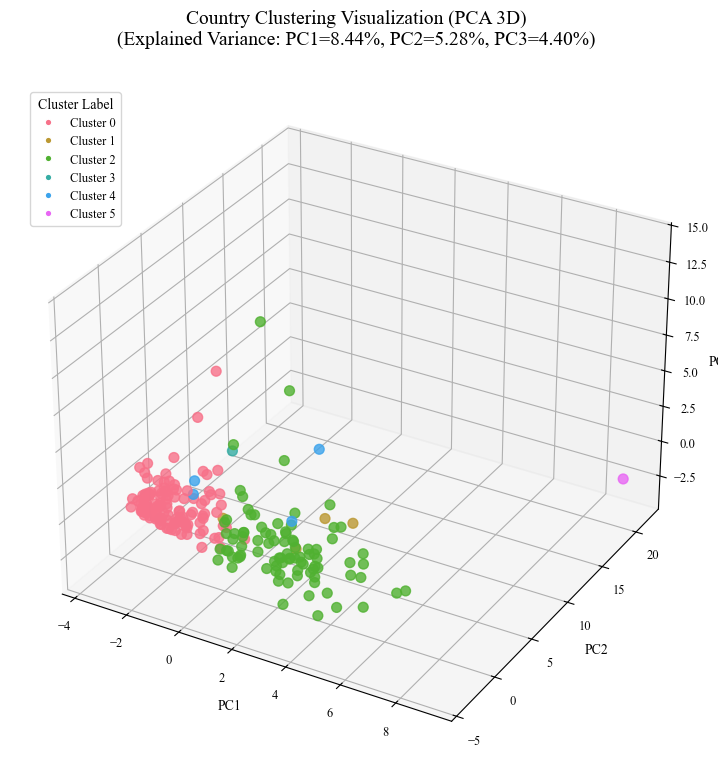

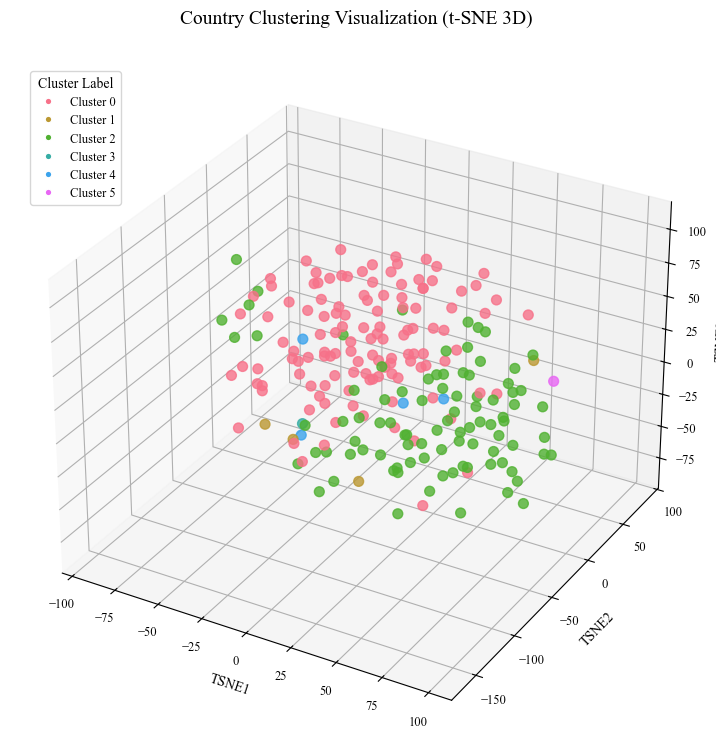

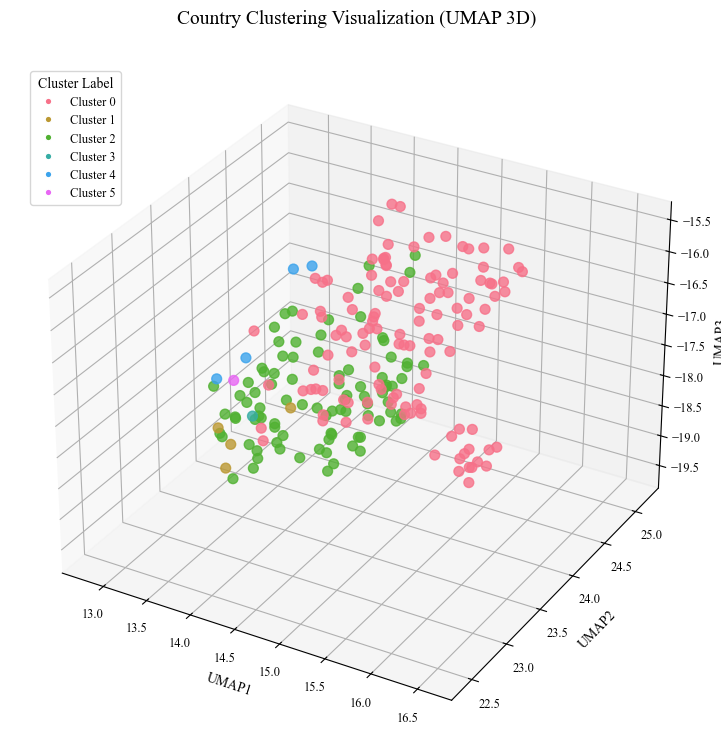

第二次修正版步骤 3.2.7 完成


In [44]:
# 步骤 3.2.7：创建静态 3D 投影图 (使用 Matplotlib) - 第二次修正版

print("开始生成第二次修正版静态 3D 投影图 (Matplotlib)...")

from mpl_toolkits.mplot3d import Axes3D

# --- 设置全局字体 ---
matplotlib.rcParams['font.family'] = 'Times New Roman'
plt.ioff() # 关闭交互模式

# --- 定义一个函数来创建 3D 图 ---
def create_3d_plot(df, x_col, y_col, z_col, title, xlabel, ylabel, zlabel, save_path):
    """
    创建并保存一个 3D 散点图。
    
    参数:
    df: 包含数据的 DataFrame
    x_col, y_col, z_col: 坐标列名
    title: 图表标题
    xlabel, ylabel, zlabel: 坐标轴标签
    save_path: 保存路径
    """
    # 增大 fig size 以容纳更长的 Z 轴标签
    fig = plt.figure(figsize=(12, 9))  # 将宽度从 10 增加到 12，高度从 8 增加到 9
    
    ax = fig.add_subplot(111, projection='3d')

    # 为每个 cluster_label 分配颜色
    colors_map = dict(zip(unique_labels, palette))
    scatter = ax.scatter(
        df[x_col],
        df[y_col],
        df[z_col],
        c=[colors_map[label] for label in df['cluster_label']],
        s=50,
        alpha=0.8
    )

    # 设置坐标轴标签和标题
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_zlabel(zlabel, fontsize=10)

    # 设置标题
    ax.set_title(title, fontsize=14, pad=20)

    # 创建图例，并减小其大小（将 markersize 从 6 减小到 4.8）
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_map[label], markersize=4.8, label=f'Cluster {label}') for label in unique_labels]
    legend = ax.legend(handles=handles, title='Cluster Label', title_fontsize=10, fontsize=9, loc='upper left')  # 保持位置在左上角

    # 调整图例框的位置，避免遮挡
    legend.set_bbox_to_anchor((0.02, 0.98), transform=ax.transAxes)

    # 确保坐标轴标签显示完整
    ax.tick_params(axis='both', which='major', labelsize=9)

    # 关键调整：确保所有内容都包含在内，特别是右侧的 Z 轴标签
    # 使用 bbox_inches='tight' 并设置 padding
    plt.subplots_adjust(right=0.85)  # 给右侧留出更多空间

    # 保存图表
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)  # 增加一点 padding
    plt.show(fig)

# --- 1. 创建 PCA 3D 静态图 ---
pca_title = f'Country Clustering Visualization (PCA 3D)\n(Explained Variance: PC1={explained_variance_ratio[0]:.2%}, PC2={explained_variance_ratio[1]:.2%}, PC3={explained_variance_ratio[2]:.2%})'
create_3d_plot(
    df_pca_for_plot_3d,
    'PC1',
    'PC2',
    'PC3',
    pca_title,
    'PC1',
    'PC2',
    'PC3',
    os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_pca_3d_static_corrected_v2.png')
)

# --- 2. 创建 t-SNE 3D 静态图 ---
if df_tsne_for_plot_3d is not None:
    create_3d_plot(
        df_tsne_for_plot_3d,
        'TSNE1',
        'TSNE2',
        'TSNE3',
        'Country Clustering Visualization (t-SNE 3D)',
        'TSNE1',
        'TSNE2',
        'TSNE3',
        os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q3_visualization_tsne_3d_static_corrected_v2.png')
    )
else:
    print("跳过 t-SNE 3D 静态图生成。")

# --- 3. 创建 UMAP 3D 静态图 ---
if df_umap_for_plot_3d is not None:
    create_3d_plot(
        df_umap_for_plot_3d,
        'UMAP1',
        'UMAP2',
        'UMAP3',
        'Country Clustering Visualization (UMAP 3D)',
        'UMAP1',
        'UMAP2',
        'UMAP3',
        os.path.join(os.path.dirname(os.getcwd()), 'results', 'q2', 'q2_visualization_umap_3d_static_corrected_v2.png')
    )
else:
    print("跳过 UMAP 3D 静态图生成。")

print("第二次修正版步骤 3.2.7 完成")